# ROSSMAN STORE

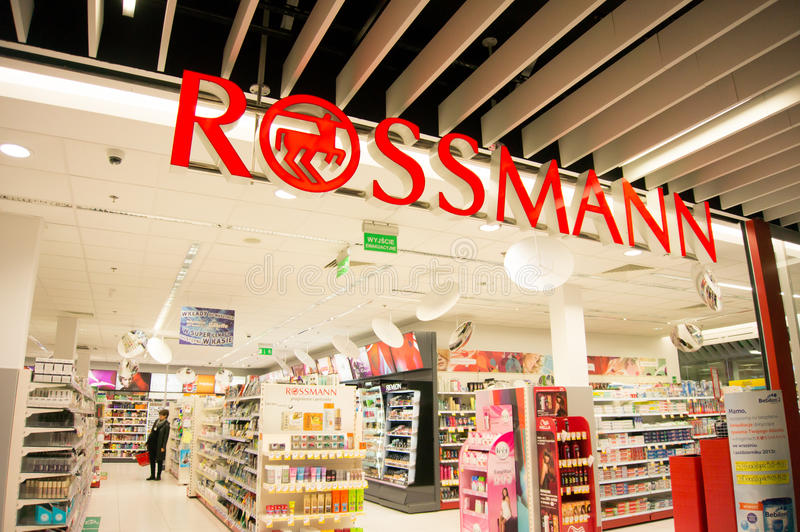

In [2]:
Image('rossmann_store.png')

## Contexto
Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada. Você pode baixar o conjunto de dados aqui: https://www.kaggle.com/c/rossmann-store-sales/data.


## Problema de Negócio
Em primeiro lugar, precisamos entender qual é o nosso problema de negócios. Portanto, criamos um contexto para nos ajudar a construir a solução. Então, vamos seguir essas quatro etapas.


- Qual é o contexto?

    * Em reunião com os líderes de cada departamento, o CEO da Rossmann fez a proposta de reformar todas as lojas.
    
    
- Qual é a causa?

     * O CEO da Rossmann quer prever quanto cada loja vai vender nas próximas 6 semanas. Ele precisa saber se o orçamento será suficiente para fazer uma reforma em cada loja.
     
     
- Quem vai liderar o projeto?

    * Precisamos de alguém que realmente saiba qual é o problema do negócio, porque ele vai liderar a solução. Portanto, ele é nosso stakeholder.
    
    
- Como ficará nossa solução?

    * Qual é o formato?
    
        - Granularidade (hora, dia, produto) ---> 6 semanas
        
        - Tipo de problema (classificação, regressão, agrupamento, etc.) ---> Regressão
        
        - Como vamos entregar? (painel, csv, Notebook) ---> Notebook
 
## Etapas do Projeto
Seguiremos todas essas etapas a seguir para a resolução do nosso projeto:

- 0.0. IMPORTS
- 1.0. DESCRIÇÃO DOS DADOS
- 2.0. FEATURE ENGINEERING
- 3.0. FILTRANDO OS DADOS
- 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS
- 5.0. PREPARAÇÃO DOS DADOS
- 6.0. SELEÇÃO DE FEATURES
- 7.0. MACHINE LEARNING
- 8.0. INTERPRETANDO OS RESULTADOS

## 0.0. IMPORTS

In [1]:
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
from matplotlib.gridspec     import GridSpec
import datetime
import inflection
from scipy                   import stats    as ss
import random                
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV
import xgboost               as xgb
import pickle
from flask                   import Flask
from IPython.display         import Image
import warnings

### 0.1. Funções de Ajuda

In [3]:
warnings.filterwarnings("ignore")

pd.set_option('max_columns', None)

def cramer_v(x, y):
    cm= np.asmatrix(pd.crosstab(x,y))
    n= cm.sum()
    r, k= cm.shape
    
    chi2= ss.chi2_contingency(cm)[0]
    chi2corr= max(0, chi2 - (k - 1) * (r-1)/n - 1)
    kcorr= k - (k - 1) ** 2 / (n - 1)
    rcorr= r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))


def mean_absolute_percentage_error(y, y_pred):
    return np.mean((abs((y - y_pred) / y)))
    
def ml_error(ml_name, y, y_pred):
    mae= mean_absolute_error(y, y_pred)
    mape= mean_absolute_percentage_error(y, y_pred)
    rmse= np.sqrt(mean_squared_error(y, y_pred))
    
    return pd.DataFrame({ 'Model Name': ml_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index= [0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.exp( yvalidation ), np.exp( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 )}, index=[0] )


plt.style.use('ggplot')

def valor_grafico(data, height_plus):
    for patch in ax.patches:
        height= patch.get_height()
        width= patch.get_width()
        left_coord= patch.get_x()

        ax.text(left_coord + width/2, height+ height_plus, '{:_}'.format(int(height)).replace('.',',').replace('_', '.'), ha= 'center')
        
def titulo(title, tamanho, y= 1):
    plt.title(title, fontsize= tamanho, fontweight= 'bold', loc= 'left', color= 'grey', y= y)

### 0.2. Carregando Dados

In [4]:
train_df_raw= pd.read_csv('train.csv', low_memory=False)
store_df_raw= pd.read_csv('store.csv')

display(store_df_raw)
display(train_df_raw)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
# Juntar as duas tabelas pelo 'Store'
raw_df= pd.merge(train_df_raw, store_df_raw, on= 'Store', how= 'inner')

raw_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


## 1.0. DESCRIÇÃO DOS DADOS

- Store - um ID único para cada loja.
- DayOfWeek - Dia correspondente da semana.
- Date - O dia do acontecimento do dado. 
- Sales - o volume de vendas.
- Customers - o número de clientes em um determinado dia.
- Open - um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta
- StateHoliday - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e finais de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = Nenhum
- SchoolHoliday - indica se (loja, data) foi afetado pelo fechamento de escolas públicas.
- StoreType - diferencia entre 4 modelos de loja diferentes: a, b, c, d
- Assortment - descreve um nível de sortimento: a = básico, b = extra, c = estendido
- CompetitionDistance - distância em metros até a loja concorrente mais próxima.
- CompetitionOpenSince [Month / Year] - fornece o mês e ano aproximados em que o concorrente mais próximo foi aberto.
- Promo - indica se uma loja está fazendo uma promoção naquele dia.
- Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando.
- Promo2Since [Year / Week] - descreve o ano e a semana em que a loja começou a participar da Promo2.
- PromoInterval - descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fev, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja.

In [6]:
df1= raw_df.copy()

In [7]:
raw_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### 1.1. Renomear Colunas

In [8]:
old_columns= raw_df.columns

snakecase= lambda x: inflection.underscore(x)

new_columns= list(map(snakecase, old_columns))

df1.columns= new_columns

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2. Dimensão dos Dados

In [10]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


### 1.3. Tipo dos Dados

In [11]:
df1['date']= pd.to_datetime(df1['date'])

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### 1.4. Valores Nulos

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Preencher Valores Nulos

- competition_distance: Colocar uma distância muito grande para mostrar que não existe competição perto.
- competition_open_since_month: Colocar o respectivo número do mês da coluna ['date'].
- competition_open_since_year: Colocar o respectivo número do ano da coluna ['date'].
- promo2_since_week: Colocar o respectivo número da semana da coluna ['date'].
- promo2_since_year: Colocar o respectivo número do ano da coluna ['date'].
- promo_interval: Preencher com 0 e criar uma nova coluna chamada ['is_promo'] onde, se o mês da coluna['date'] estiver na coluna ['promo_interval'] retorna 1(possui promoção) e 0 para o restante.

In [13]:
# competition_distance 
df1['competition_distance'].fillna(200000, inplace= True)

# competition_open_since_month
df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace= True)

# competition_open_since_year
df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace= True)

# promo2_since_week
df1['promo2_since_week'].fillna(df1['date'].dt.week, inplace= True)

# promo2_since_year    
df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace= True)

# promo_interval    
month_map= {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez', }

df1['promo_interval'].fillna(0, inplace= True)

df1['month_map']= df1['date'].dt.month.map(month_map)

df1['is_promo']= df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Mudança de Tipo dos Dados

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [16]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year']= df1['competition_open_since_year'].astype('int64')  
df1['promo2_since_week']= df1['promo2_since_week'].astype('int64')
df1['promo2_since_year']= df1['promo2_since_year'].astype('int64')             

### 1.7. Estatística Descritiva

In [17]:
num_att= df1.select_dtypes(include= ['int64', 'float64'])
cat_att= df1.select_dtypes(include= ['object'])

#### 1.7.1. Atributos Numéricos

In [18]:
num_att.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.44,12547.65,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.79,3.31,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.32,5.52,1900.0,2008.0,2012.0,2014.0,2015.0


#### 1.7.2. Atributos Categóricos

In [19]:
for i in cat_att.columns:
    print(i)
    print('Quantidade de dados únicos: {}'.format(cat_att[i].unique().shape[0]))
    print('Dados únicos: ', cat_att[i].unique())
    print('-'*100)

state_holiday
Quantidade de dados únicos: 4
Dados únicos:  ['0' 'a' 'b' 'c']
----------------------------------------------------------------------------------------------------
store_type
Quantidade de dados únicos: 4
Dados únicos:  ['c' 'a' 'd' 'b']
----------------------------------------------------------------------------------------------------
assortment
Quantidade de dados únicos: 3
Dados únicos:  ['a' 'c' 'b']
----------------------------------------------------------------------------------------------------
promo_interval
Quantidade de dados únicos: 4
Dados únicos:  [0 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
----------------------------------------------------------------------------------------------------
month_map
Quantidade de dados únicos: 12
Dados únicos:  ['Jul' 'Jun' 'May' 'Apr' 'Mar' 'Fev' 'Jan' 'Dez' 'Nov' 'Out' 'Set' 'Aug']
----------------------------------------------------------------------------------------------------


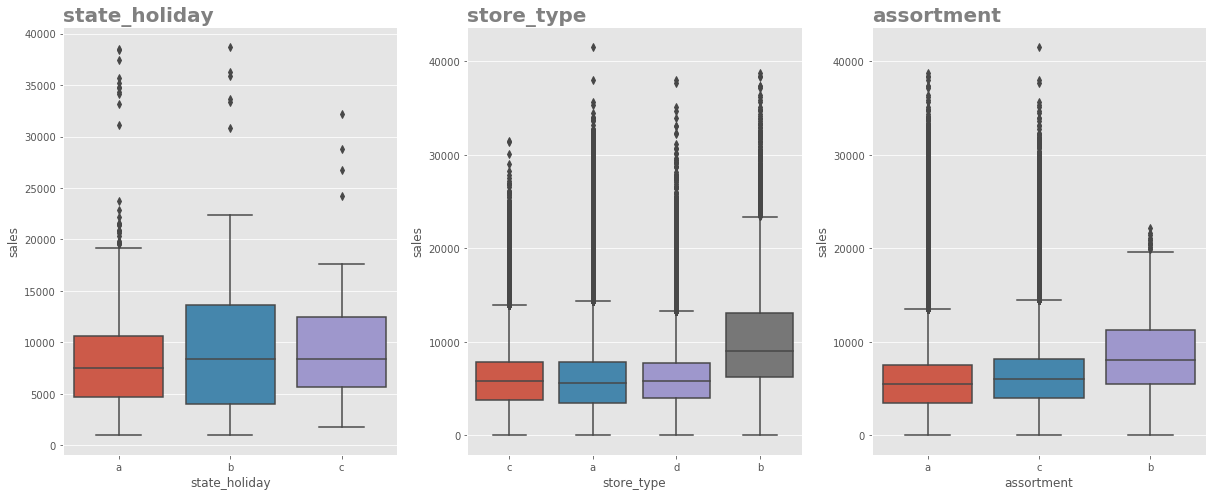

In [20]:
plt.figure(figsize= (17, 7))


plt.subplot(1, 3, 1)
# state_holiday quando tiver feriado e quando as vendas forem maior que 0
sns.boxplot(x= 'state_holiday', y= 'sales', data= df1[(df1['state_holiday'] != '0') & (df1['sales'] != 0)])
titulo('state_holiday', 20)

plt.subplot(1, 3, 2)
sns.boxplot(x= 'store_type', y= 'sales', data= df1)
titulo('store_type', 20)


plt.subplot(1, 3, 3)
sns.boxplot(x= 'assortment', y= 'sales', data= df1)
titulo('assortment', 20)


plt.tight_layout()

## 2.0. FEATURE ENGINEERING

In [21]:
df2= df1.copy()

### 2.1. Mapa Mental de Hipóteses

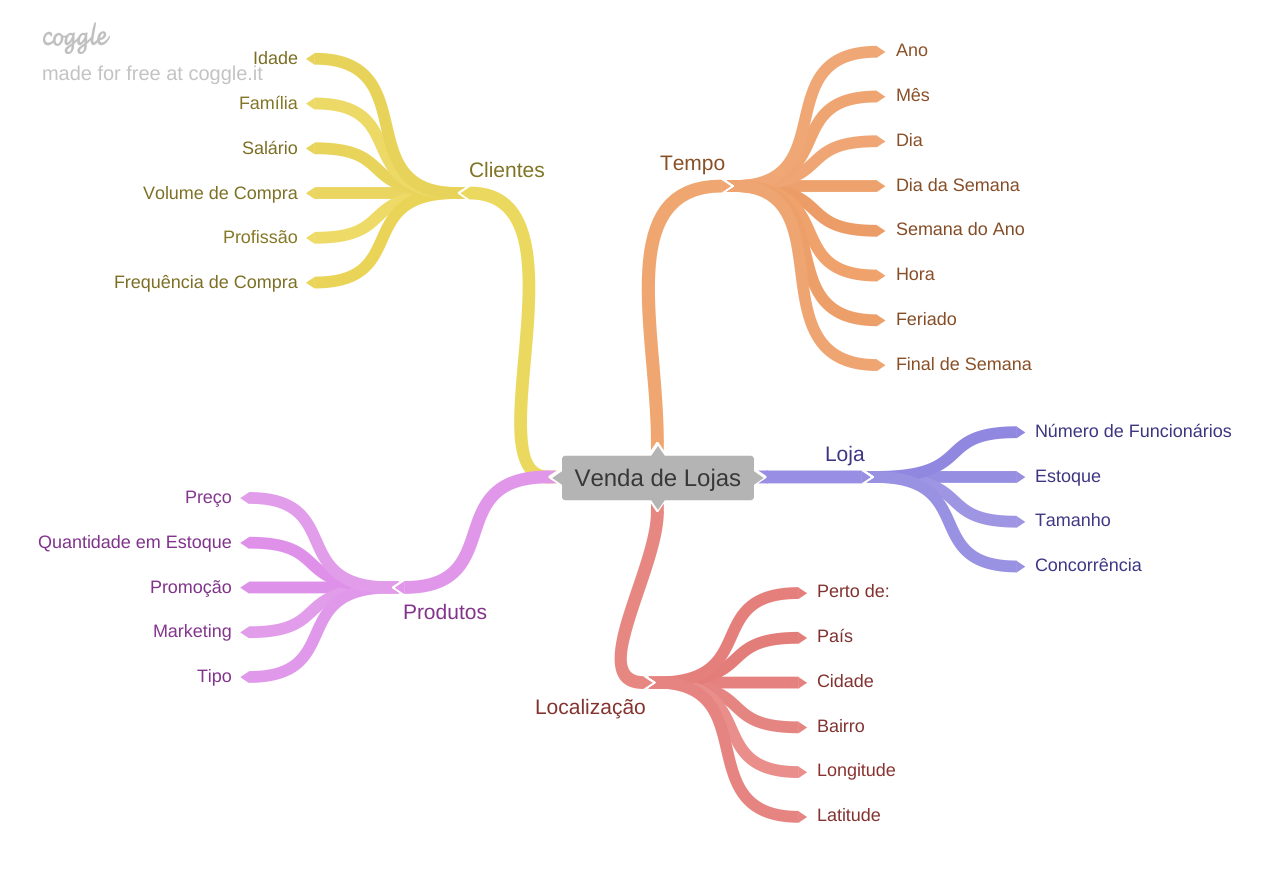

In [22]:
Image('Mindmap_Venda_de_Lojas.png')

### 2.2. Criando Hipóteses

#### 2.2.1 Hipóteses Loja

**1.** Quanto maior o estoque, maior o número de vendas.

**2.** Quanto maior o tamanho, maior o número de vendas.

**3.** Loja com mais funcionários tem o número maior de vendas.

**4.** Lojas com competidores a mais tempo devem vender mais.

**5.** O tipo de loja influencia no número de vendas.

**6.** O sortimendo da loja influencia no número de vendas.

#### 2.2.2 Hipóteses Produto

**1.** Quanto mais é gasto com Marketing, maior é o número de vendas.

**2.** Lojas com mais tempo em promoção vendem mais.

**3.** Quanto menor for o preço dos produtos, maior é o número de vendas.

**4.** Quanto mais produtos em estoque tiver, maior é o número de vendas.

#### 2.2.3 Hipóteses Tempo

**1.** Lojas devem vender mais ao longo dos anos.

**2.** Lojas devem vender mais no segundo semestre do ano.

**3.** Lojas devem vender mais depois do dia 10 de cada mês.

**4.** Lojas devem vender menos nos finais de semana.

**5.** Lojas devem vender menos nos feriados escolares.

**6.** Lojas devem vender mais no Natal.

### 2.3. Lista final de Hipóteses

**H1.** Loja com menos concorrência vende mais.

**H2.** O tipo de loja influencia no número de vendas.

**H3.** O sortimendo da loja influencia no número de vendas.

**H4.** Lojas com competidores a mais tempo devem vender mais.

**H5.** Lojas devem vender mais ao longo dos anos.

**H6.** Lojas devem vender mais no segundo semestre do ano.

**H7.** Lojas devem vender mais depois do dia 10 de cada mês.

**H8.** Lojas devem vender menos nos finais de semana.

**H9.** Lojas devem vender menos nos feriados escolares.

**H10.** Lojas devem vender mais no Natal.

### 2.4. Feature Engineering
Vamos criar features para nos auxiliar ao longo do projeto.

- Criaremos colunas para o ano, mês, dia, semana do ano e semana com ano.
- Criaremos também uma colunas para o tempo que uma loja possui um concorrente em meses.
- Trocaremos o nome dos dados das colunas state_holiday e assortment para os valores descritos na descrição dos dados.

In [23]:
# Ano
df2['year']= df2['date'].dt.year

# Mês
df2['month']= df2['date'].dt.month

# Dia
df2['day']= df2['date'].dt.day

# Semana do ano numérico
df2['week_of_year']= df2['date'].dt.weekofyear

# Semana do ano Ano-Mês
df2['year_week']= df2['date'].dt.strftime('%Y-%W')

# Tempo da competition
df2['competition_since']= pd.to_datetime(df2.apply(lambda x: str(x['competition_open_since_year']) + '-' + str(x['competition_open_since_month']) + '-' + '01', axis= 1))
df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# state_holiday
df2['state_holiday']= df2['state_holiday'].map({'a' : 'public holiday', 'b' : 'Easter holiday', 'c' : 'Christmas', '0' : 'regular'})

# assortment
df2['assortment']= df2['assortment'].map({'a' : 'basic', 'b' : 'extra', 'c' : 'extended'})

## 3.0. FILTRANDO OS DADOS

In [24]:
df3= df2.copy()

### 3.1. Filtragem das Linhas

Vamos apenas trabalhar com os dias que as lojas estavam abertas e que as vendas foram maior que 0.

In [25]:
df3= df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Filtragem das Colunas
Podemos filtrar as seguintes colunas:
- open: Pois depois da filtragem das linhas, todas possuem o mesmo valor 1.
- customers: Pois não sabemos quantos cliente irão entrar na loja no futuro.
- promo_interval: Pois serviu como auxiliar para a construção da coluna ['is_promo'].
- month_map: Pois serviu como auxiliar para a construção da coluna ['is_promo'].

In [26]:
df3.drop(columns= ['open', 'customers', 'promo_interval', 'month_map'], inplace= True)

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month'],
      dtype='object')

## 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [27]:
df4= df3.copy()

### 4.1. Análise Univariada

#### 4.1.1 Variável Resposta

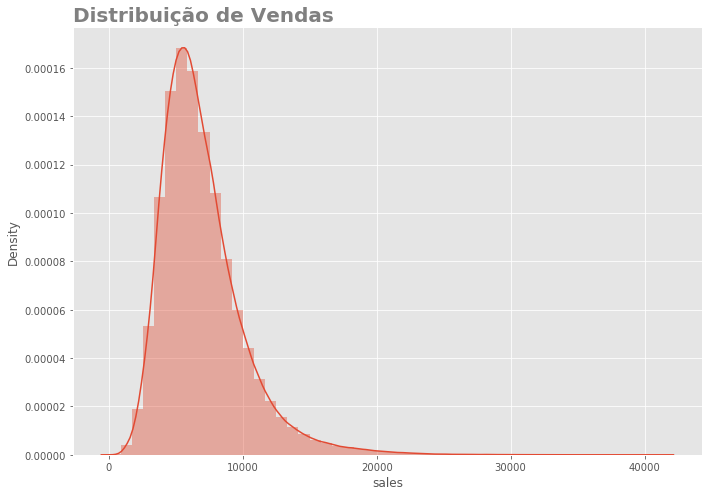

In [28]:
plt.figure(figsize= (10, 7))

sns.distplot(df4['sales'], kde= True)
titulo('Distribuição de Vendas', 20);

plt.tight_layout()

#### 4.1.2 Variável Numérica

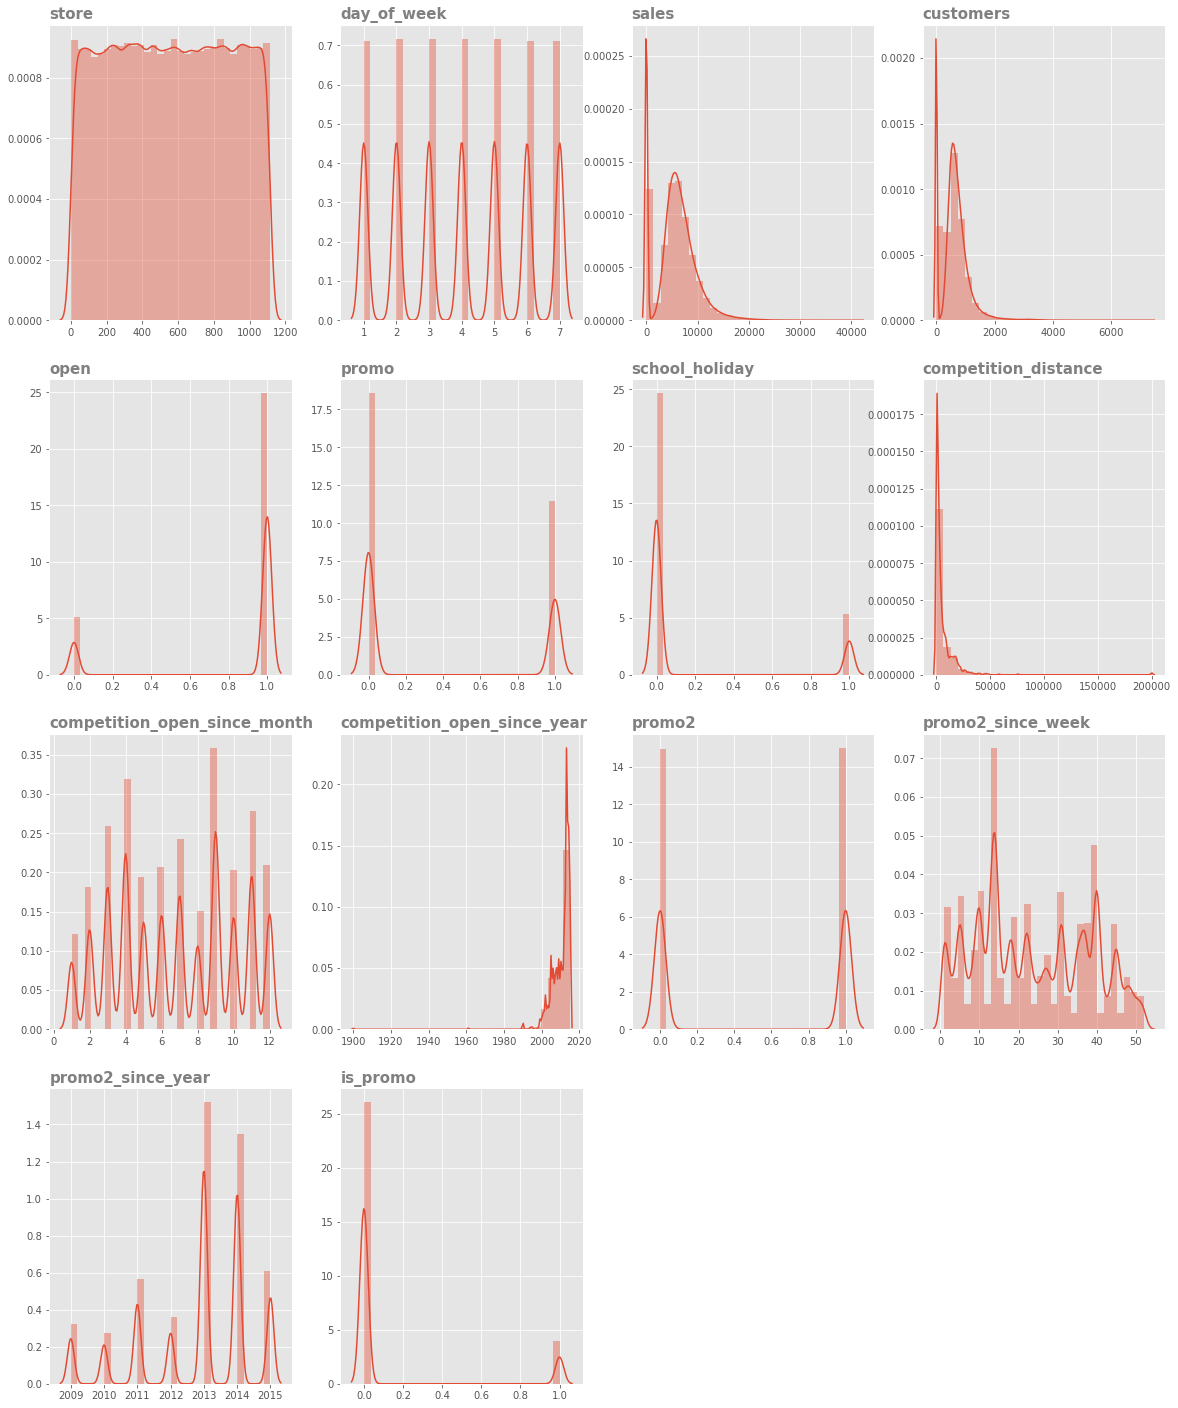

In [29]:
plt.figure(figsize= (20, 25))

n= 1

for i in num_att.columns:
    plt.subplot(4, 4, n)
    sns.distplot(num_att[i], bins= 30)
    titulo(i, 15)
    plt.xlabel('')
    plt.ylabel('')
    
    n+= 1

#### 4.1.3 Variável Categórica

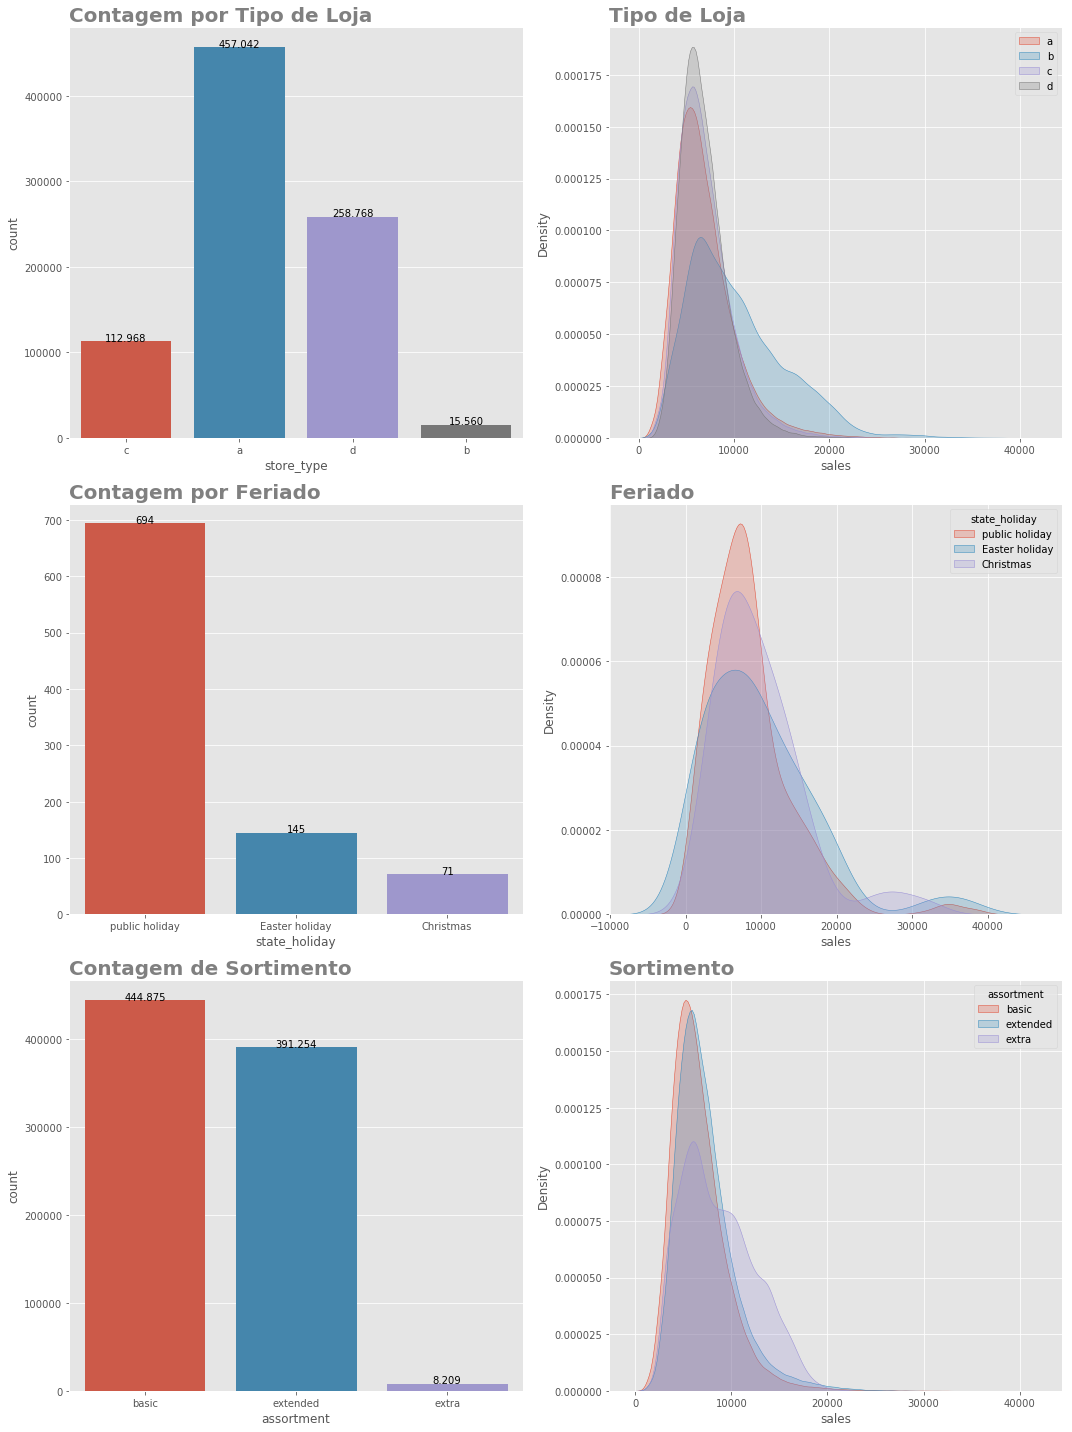

In [30]:
plt.figure(figsize= (15, 20))

# Gráfico 1
plt.subplot(3, 2, 1)
ax= sns.countplot(x= df4['store_type'])
titulo('Contagem por Tipo de Loja', 20)
valor_grafico(df4, 50)


# Gráfico 2
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label= 'a', shade= True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label= 'b', shade= True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label= 'c', shade= True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label= 'd', shade= True)
titulo('Tipo de Loja', 20)
plt.legend()


# Gráfico 3
plt.subplot(3, 2, 3)
ax= sns.countplot(x= df4[df4['state_holiday'] != 'regular']['state_holiday'])
titulo('Contagem por Feriado', 20)
valor_grafico(df4[df4['state_holiday'] != 'regular'], 0)


# Gráfico 4
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label= 'public holiday', shade= True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label= 'Easter holiday', shade= True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label= 'Christmas', shade= True)
plt.legend(title= 'state_holiday')
titulo('Feriado', 20)


# Gráfico 5
plt.subplot(3, 2, 5)
ax= sns.countplot(x= df4['assortment'])
titulo('Contagem de Sortimento', 20)
valor_grafico(df4, 0)

    
# Gráfico 6
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basic', shade= True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label= 'extended', shade= True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra', shade= True)
plt.legend(title= 'assortment')
titulo('Sortimento', 20);

plt.tight_layout()

### 4.2. Análise Bivariada

### **H1.** Loja com menos concorrência vende mais.
**Falso**. Percebemos que os maiores valores com vendas estão onde as lojas possuem concorrente próximo.

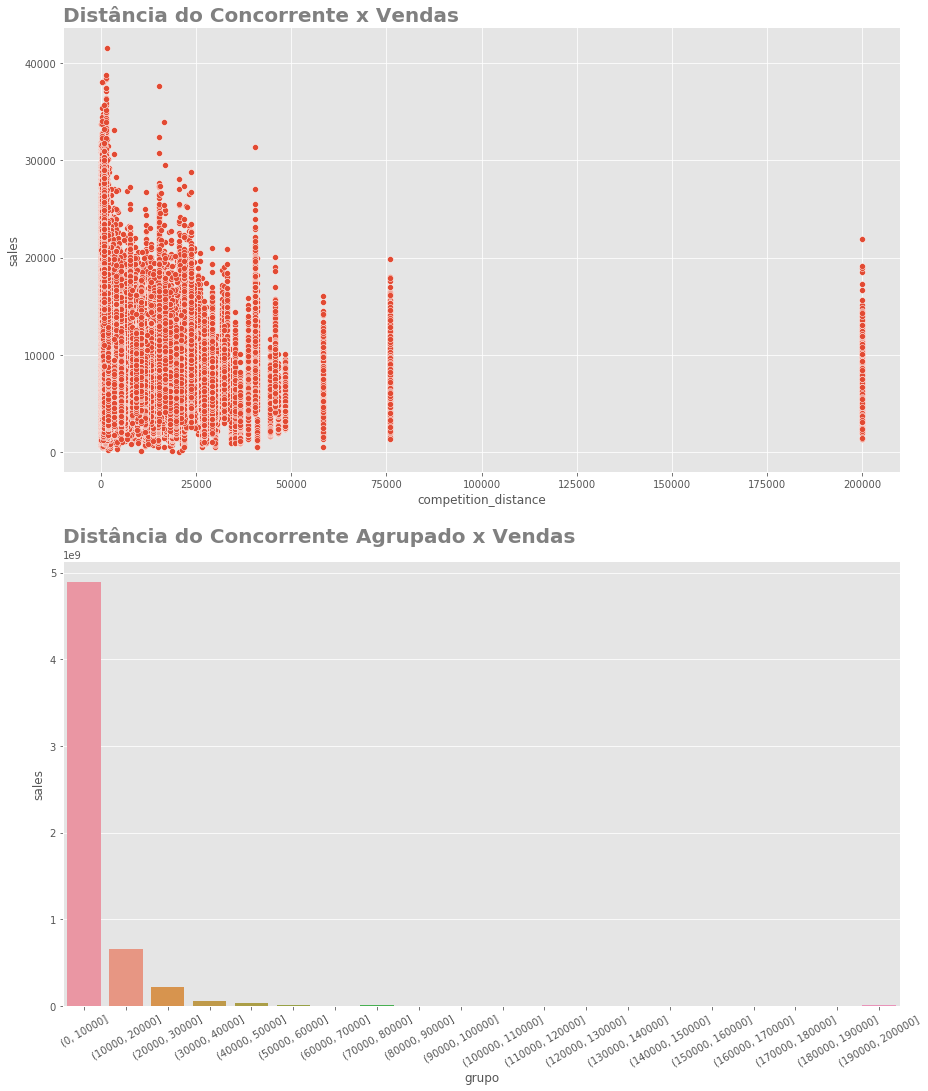

In [31]:
plt.figure(figsize= (15, 18))

plt.subplot(2, 1, 1)
sns.scatterplot(x= 'competition_distance', y= 'sales', data= df4)
titulo('Distância do Concorrente x Vendas', 20)

plt.subplot(2, 1, 2)
# Vamos separar a distância dos concorrentes por grupos de mil em mil.

grupos= list(range(0,200001, 10000))

aux1= df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux1['grupo']= pd.cut(x= aux1['competition_distance'], bins= grupos)
aux2= aux1[['grupo', 'sales']].groupby('grupo').sum().reset_index()

sns.barplot(x='grupo', y= 'sales', data= aux2)
titulo('Distância do Concorrente Agrupado x Vendas', 20, 1.03)
plt.xticks(rotation= 30);

### **H2.** O tipo de loja influencia no número de vendas.
**Falso**. Observamos que a média de vendas é muito parecida entre as lojas e que a soma vendida pelos tipos de loja obedece o padrão de contagem do número de lojas, fazendo acreditar que se o número de lojas fosse o mesmo, o número de vendas seria o mesmo.

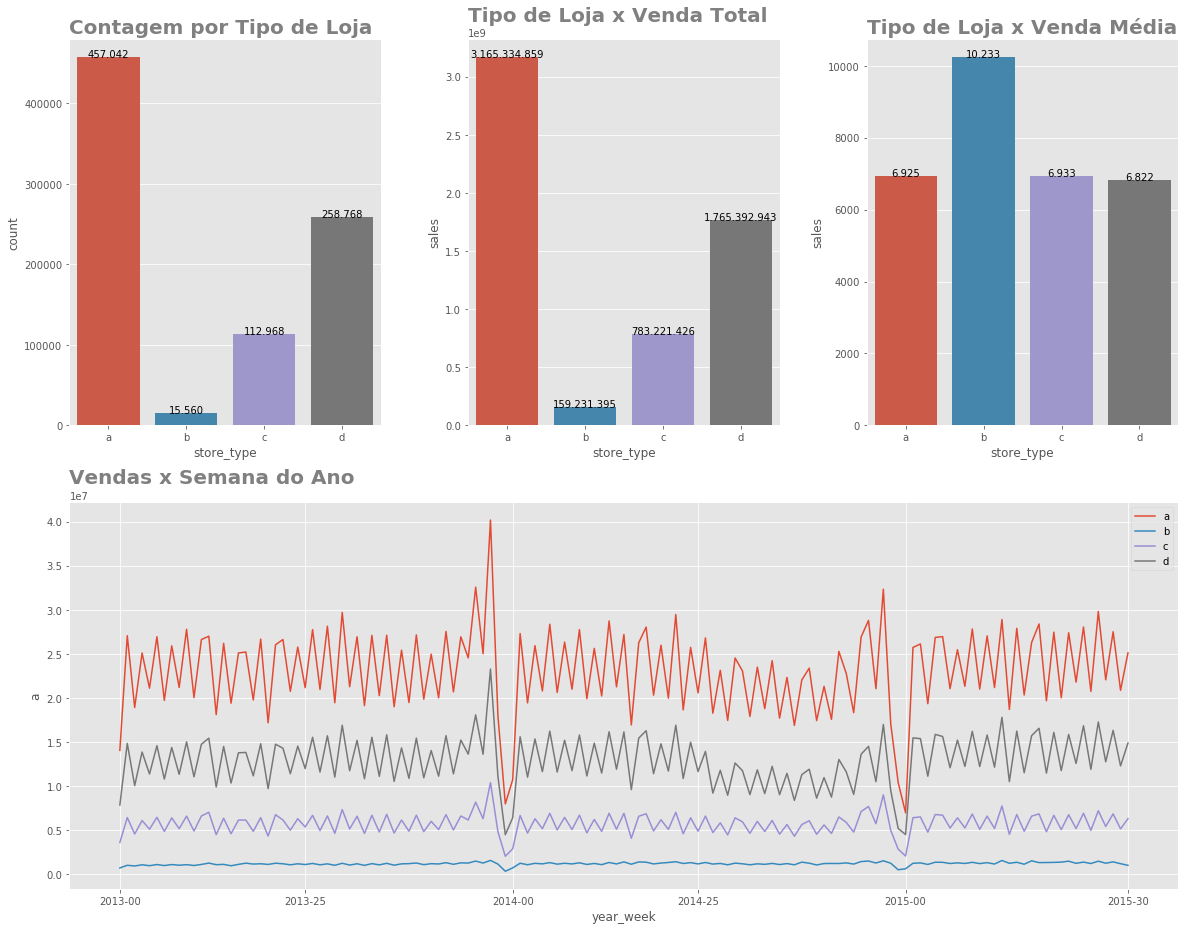

In [32]:
plt.figure(figsize= (17, 13))

grid= GridSpec(2, 3)


plt.subplot(grid[0, 0])
ax= sns.countplot(x= 'store_type', data= df4, order= ['a', 'b', 'c', 'd'])
titulo('Contagem por Tipo de Loja', 20)
valor_grafico(df4, 0)


plt.subplot(grid[0, 1])
ax= sns.barplot(x= 'store_type', y= 'sales', data= df4, order= ['a', 'b', 'c', 'd'], estimator= sum, ci= None)
titulo('Tipo de Loja x Venda Total', 20, 1.03)
valor_grafico(df4, 0)


plt.subplot(grid[0, 2])
ax= sns.barplot(x= 'store_type', y= 'sales', data= df4, order= ['a', 'b', 'c', 'd'], ci= None)
titulo('Tipo de Loja x Venda Média', 20)
valor_grafico(df4, 0)


plt.subplot(grid[1, :])
aux1= df4.pivot_table(values= 'sales', index= 'year_week', columns= 'store_type', aggfunc= sum)
sns.lineplot(x= 'year_week', y= 'a', data= aux1, ci= None, estimator= sum, label= 'a')
sns.lineplot(x= 'year_week', y= 'b', data= aux1, ci= None, estimator= sum, label= 'b')
sns.lineplot(x= 'year_week', y= 'c', data= aux1, ci= None, estimator= sum, label= 'c')
sns.lineplot(x= 'year_week', y= 'd', data= aux1, ci= None, estimator= sum, label= 'd')
plt.legend()
titulo('Vendas x Semana do Ano', 20, 1.035)
plt.xticks(['2013-00', '2013-25', '2014-00', '2014-25', '2015-00', '2015-30'])

plt.tight_layout();

### **H3.** O sortimendo da loja influencia no número de vendas.
**Falso**. A diferença da soma total de vendas é explicada pela contagem que cada tipo de sortimento possui.

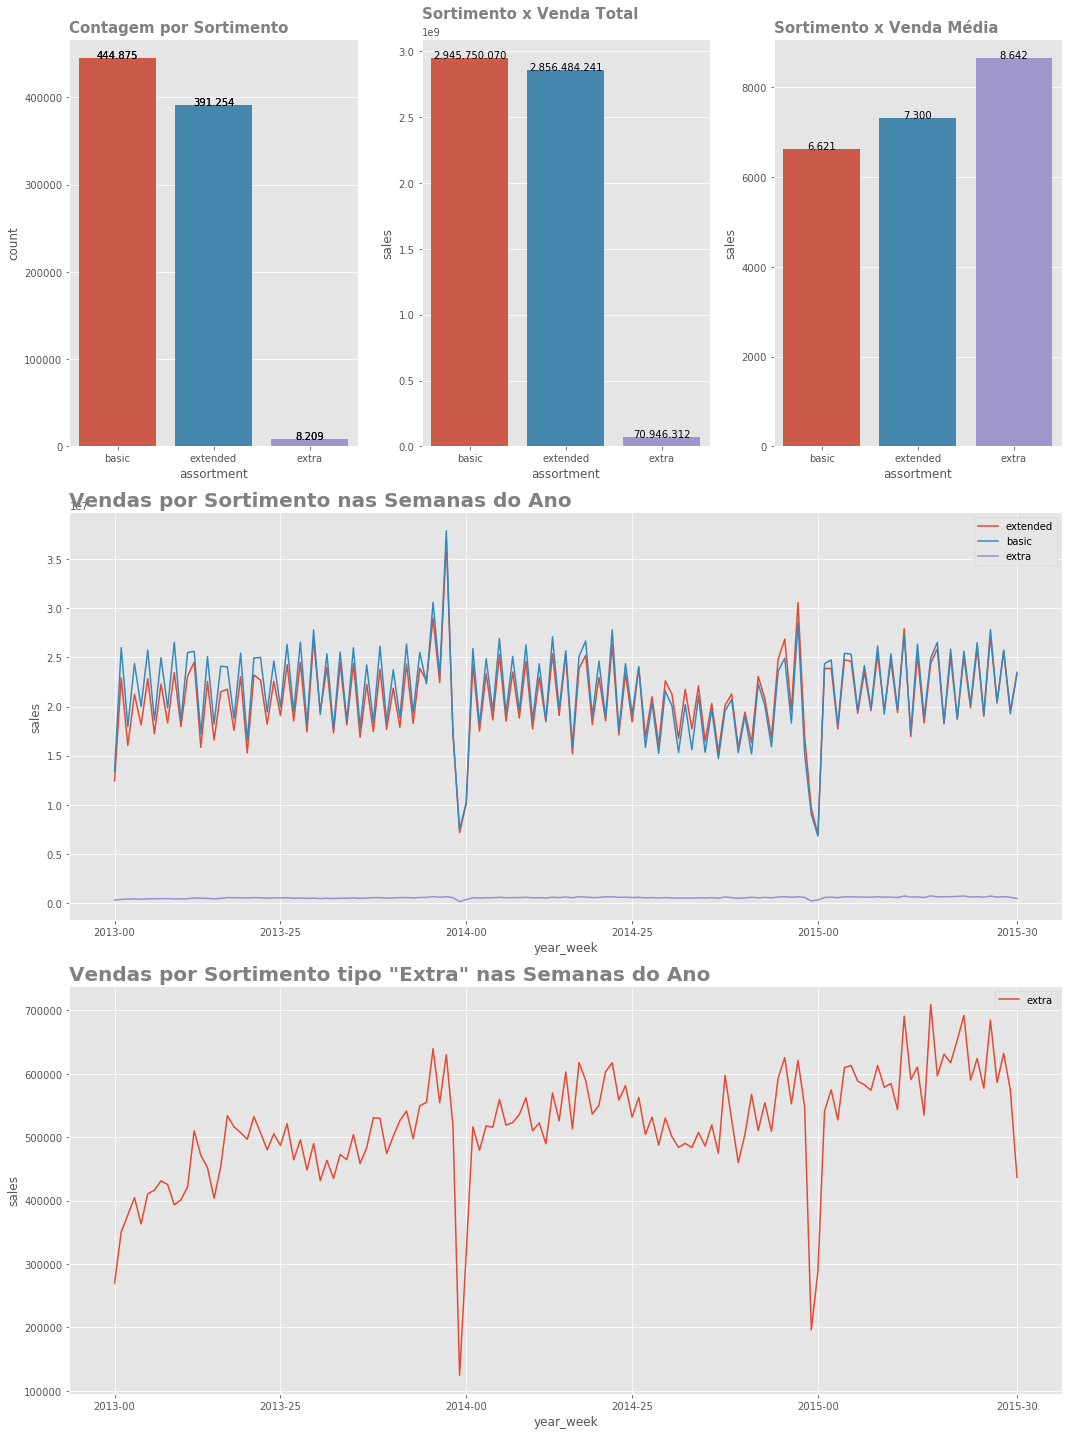

In [33]:
plt.figure(figsize= (15, 20))

grid= GridSpec(3, 3)

# Gráfico 1
plt.subplot(grid[0, 0])
ax= sns.countplot(x= 'assortment', data= df4)
valor_grafico(df4, 0)
titulo('Contagem por Sortimento', 15)
valor_grafico(df4, 0)

# Gráfico 2
plt.subplot(grid[0, 1])
ax= sns.barplot(x= 'assortment', y= 'sales', data= df4, ci= None, estimator= sum)
titulo('Sortimento x Venda Total', 15, 1.035)
valor_grafico(df4, 0)

# Gráfico 3
plt.subplot(grid[0, 2])
ax= sns.barplot(x= 'assortment', y= 'sales', data= df4, ci= None)
titulo('Sortimento x Venda Média', 15)
valor_grafico(df4, 0)

# Gráfico 4
plt.subplot(grid[1, :])
aux2= df4.pivot_table(index= 'year_week', values= 'sales', columns= 'assortment', aggfunc= sum)
sns.lineplot(x= 'year_week', y= 'extended', data= aux2, ci= None, estimator= sum, label= 'extended')
sns.lineplot(x= 'year_week', y= 'basic', data= aux2, ci= None, estimator= sum, label= 'basic')
sns.lineplot(x= 'year_week', y= 'extra', data= aux2, ci= None, estimator= sum, label= 'extra')
plt.legend()
titulo('Vendas por Sortimento nas Semanas do Ano', 20)
plt.ylabel('sales')
plt.xticks(['2013-00', '2013-25', '2014-00', '2014-25', '2015-00', '2015-30'])

# Gráfico 5
plt.subplot(grid[2, :])
sns.lineplot(x= 'year_week', y= 'extra', data= aux2, ci= None, estimator= sum, label= 'extra')
titulo('Vendas por Sortimento tipo "Extra" nas Semanas do Ano', 20)
plt.ylabel('sales')
plt.xticks(['2013-00', '2013-25', '2014-00', '2014-25', '2015-00', '2015-30'])

plt.tight_layout();

### **H4.** Lojas com competidores a mais tempo devem vender mais.
**Falso**. Não há correlação significativa entre o tempo da loja com competidores e vendas.

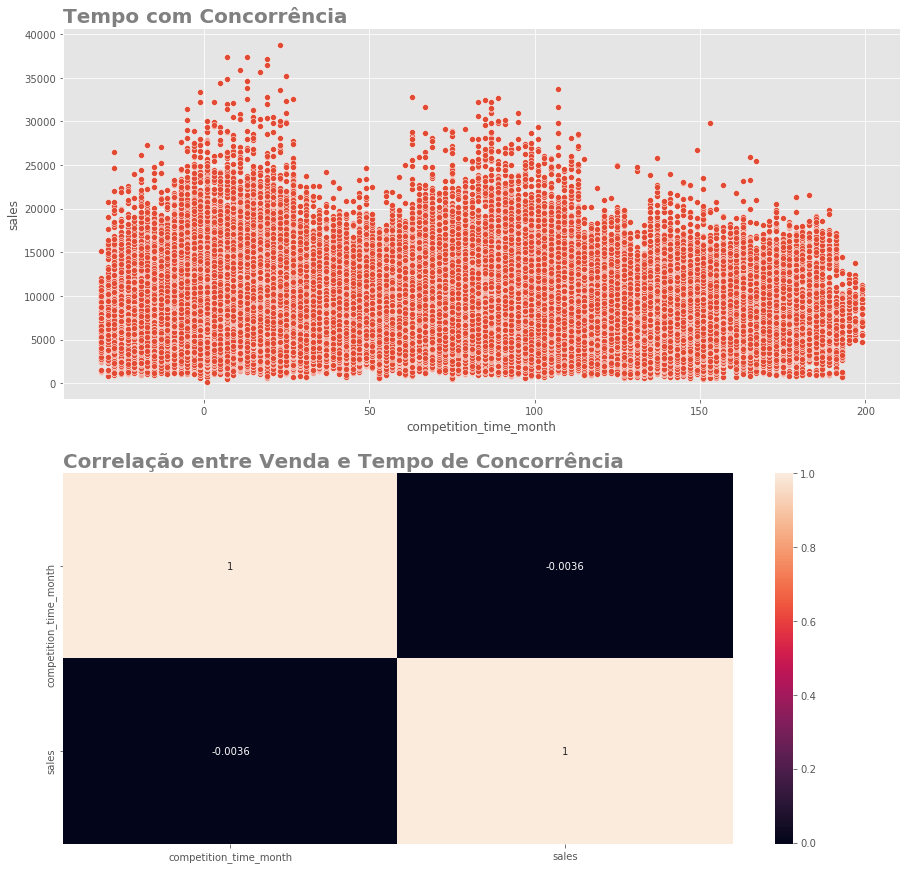

In [34]:
plt.figure(figsize= (15, 15))

plt.subplot(2,1,1)
sns.scatterplot(x= 'competition_time_month', y= 'sales', data= df4[(df4['competition_time_month'] <200) & df4['competition_time_month'] != 0])
titulo('Tempo com Concorrência', 20)

plt.subplot(2, 1, 2)
sns.heatmap(df4[['competition_time_month', 'sales']].corr(), annot= True)
titulo('Correlação entre Venda e Tempo de Concorrência', 20);

### **H5.** Lojas devem vender mais ao longo dos anos.
**Falso**. Pois de 2013 para 2014 tivemos uma queda nas vendas. O ano de 2015 ainda não foi finalizado na base de dados.

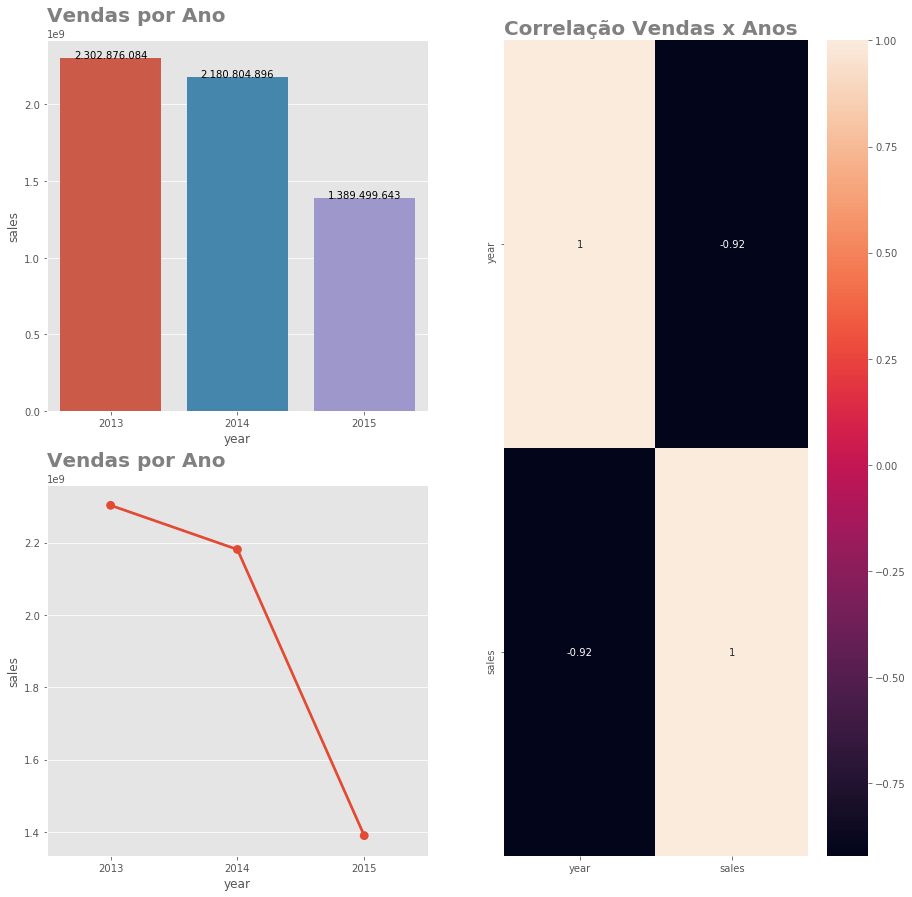

In [35]:
plt.figure(figsize= (15, 15))

grid= GridSpec(2, 2)

aux1= df4[['sales', 'year']].groupby('year').sum().reset_index()

# Gráfico 1
plt.subplot(grid[0, 0])
ax= sns.barplot(x= 'year', y= 'sales', data= aux1)
titulo('Vendas por Ano', 20, 1.035)
valor_grafico(aux1, 0)

# Gráfico 2
plt.subplot(grid[1, 0])
ax= sns.pointplot(x= 'year', y= 'sales', data= aux1)
titulo('Vendas por Ano', 20, 1.035)

# Gráfico 3
plt.subplot(grid[:, 1])
sns.heatmap(aux1.corr(), annot= True);
titulo('Correlação Vendas x Anos', 20)

### **H6.** Lojas devem vender mais no segundo semestre do ano.
**Falso**. A correlação entre vendas e semestre é quase nula e mas mesmo assim é negativa nos dizendo que o primeiro semestre tende a vender um pouco mais.

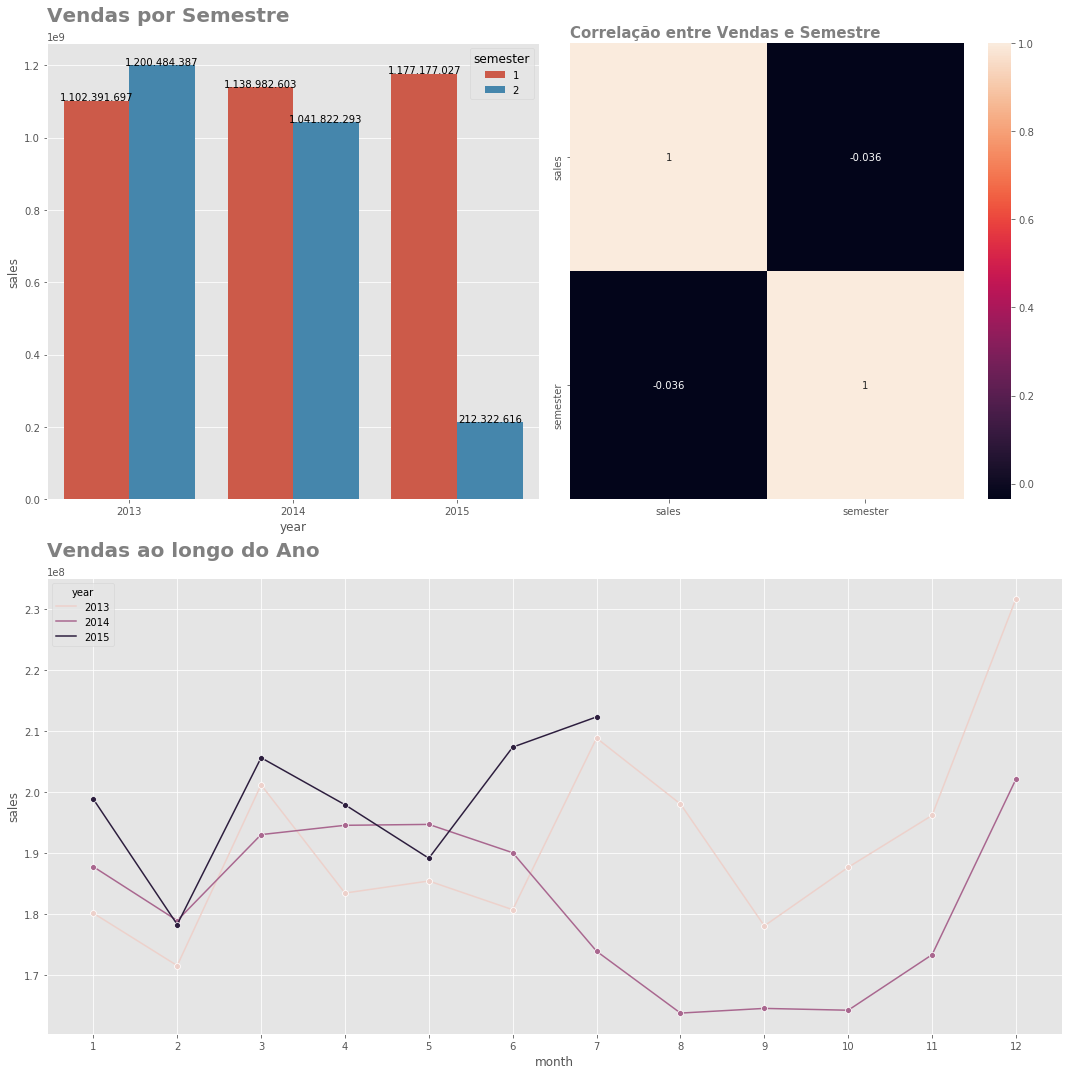

In [36]:
plt.figure(figsize= (15, 15))

grid= GridSpec(2, 2)

aux1= df4[['month', 'year', 'sales']].groupby(['year', 'month']).sum().reset_index()
aux1['semester']= aux1['month'].apply(lambda x: 1 if x < 7 else 2)

plt.subplot(grid[0, 0])
ax= sns.barplot(x= 'year', y= 'sales', data= aux1, hue= 'semester', ci= None, estimator= sum)
titulo('Vendas por Semestre', 20, 1.035)
valor_grafico(aux1, 0)

plt.subplot(grid[0, 1])
sns.heatmap(aux1[['sales', 'semester']].corr(), annot= True)
titulo('Correlação entre Vendas e Semestre', 15)

plt.subplot(grid[1, :])
sns.lineplot(x= 'month', y= 'sales', data= aux1, hue= 'year', ci= None, estimator= sum, marker= 'o')
plt.xticks(aux1['month'].unique())
titulo('Vendas ao longo do Ano', 20, 1.035)

plt.tight_layout();

### **H7.** Lojas vendem mais depois do dia 10 de cada mês.
**Verdadeiro**. A soma da venda das lojas é bem equilibrada ao longo do mês fazendo com que as lojas vendam mais depois do dia 10 por ter mais dias.

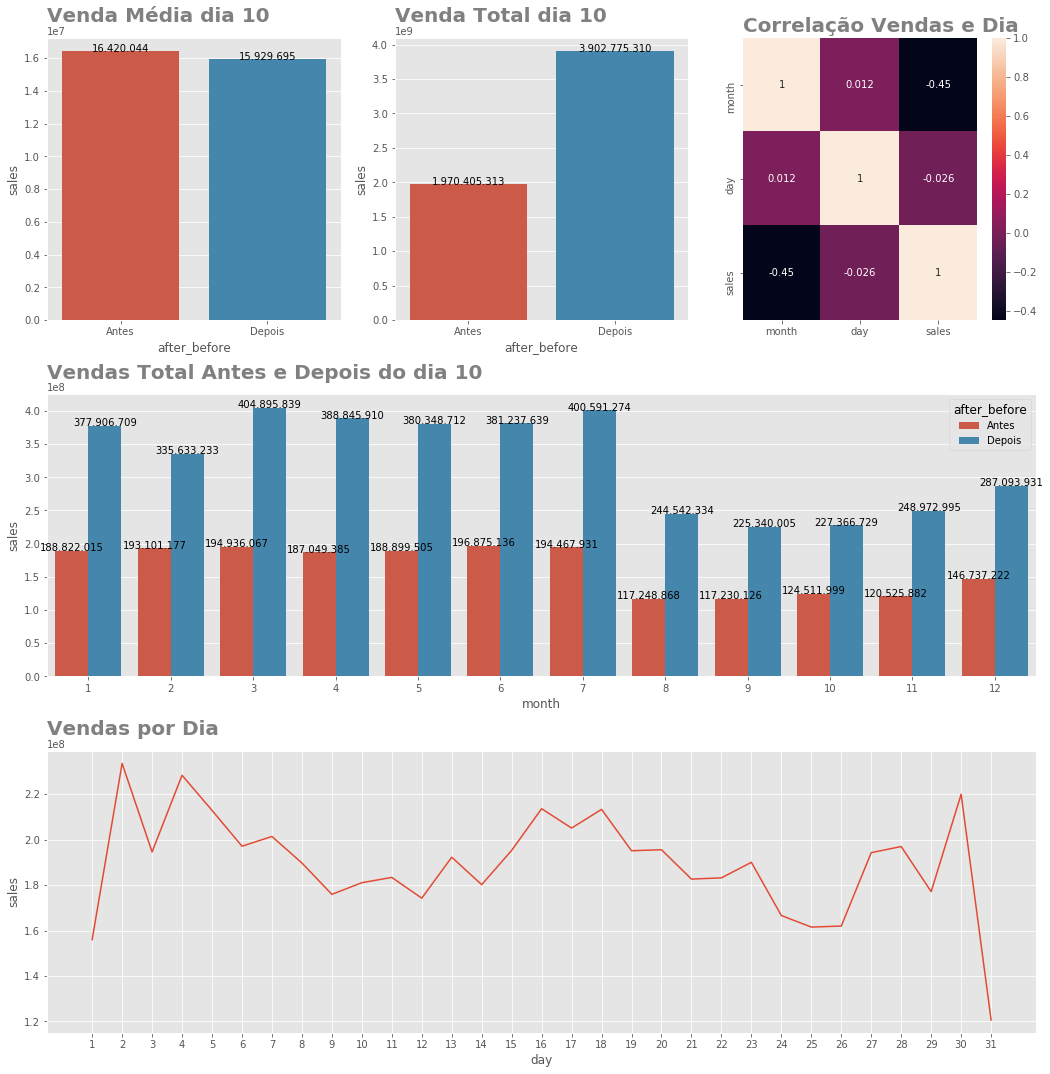

In [37]:
plt.figure(figsize= (15, 15))

aux1= df4[['sales', 'day', 'month']].groupby(['month', 'day']).sum().reset_index()
aux1['after_before']= aux1['day'].apply(lambda x: 'Antes' if x <= 10 else 'Depois')

grid= GridSpec(3, 3)

plt.subplot(grid[0, 0])
ax= sns.barplot(x= 'after_before', y= 'sales', data= aux1, ci= None)
titulo('Venda Média dia 10', 20, 1.035)
valor_grafico(aux1, 0)

plt.subplot(grid[0, 1])
ax= sns.barplot(x= 'after_before', y= 'sales', data= aux1, ci= None, estimator= sum)
titulo('Venda Total dia 10', 20, 1.035)
valor_grafico(aux1, 0)


plt.subplot(grid[0, 2])
sns.heatmap(aux1.corr(), annot= True)
titulo('Correlação Vendas e Dia', 20)


plt.subplot(grid[1, :])
ax= sns.barplot(x= 'month', y= 'sales', data= aux1, hue= 'after_before', ci= None, estimator= sum)
titulo('Vendas Total Antes e Depois do dia 10', 20, 1.035)
valor_grafico(aux1, 0)

plt.subplot(grid[2, :])
sns.lineplot(x= 'day', y= 'sales', data= aux1, ci= None, estimator= sum)
titulo('Vendas por Dia', 20, 1.035)
plt.xticks(range(1,32))




plt.tight_layout()

### **H8.** Lojas com promoções a mais tempo devem vender mais.
**Falso**. Observamos que as lojas que tiverem apenas a promo tiveram um resultado levemente superior à aquelas que fizeram promo e promo2

In [38]:
aux1= df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales', ascending= False)
aux1

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


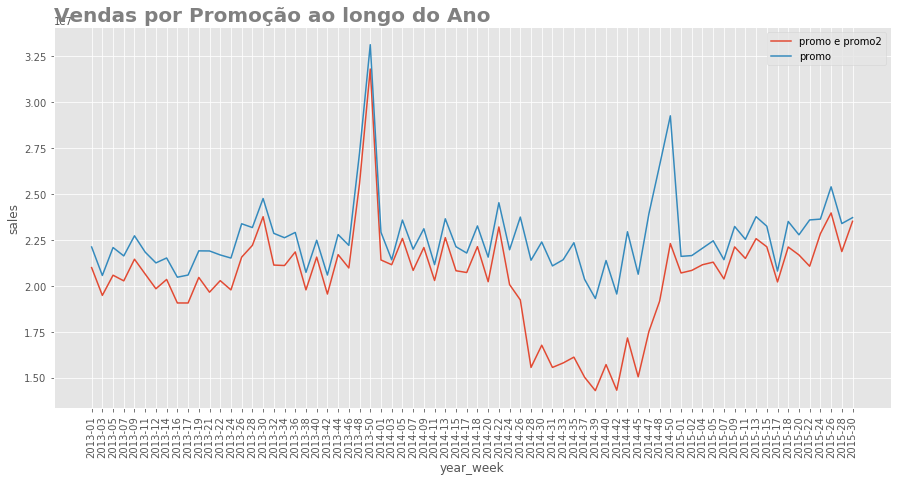

In [39]:
plt.figure(figsize= (15, 7))

aux1= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['sales', 'year_week']].groupby('year_week').sum().reset_index()
sns.lineplot(x= 'year_week', y= 'sales', data= aux1, label= 'promo e promo2', estimator= sum)

aux2= df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['sales', 'year_week']].groupby('year_week').sum().reset_index()
sns.lineplot(x= 'year_week', y= 'sales', data= aux2, label= 'promo', estimator= sum)
titulo('Vendas por Promoção ao longo do Ano', 20)
plt.xticks(rotation= 90);

### **H9.** Lojas devem vender menos nos feriados escolares.
**Falso**. Os dias "normais" representam a grande maioria dos dias do ano e por isso possuem uma grande diferença na soma de vendas, porém quando analisamos a média de vendas, os dias com feriado escolares vendem mais.

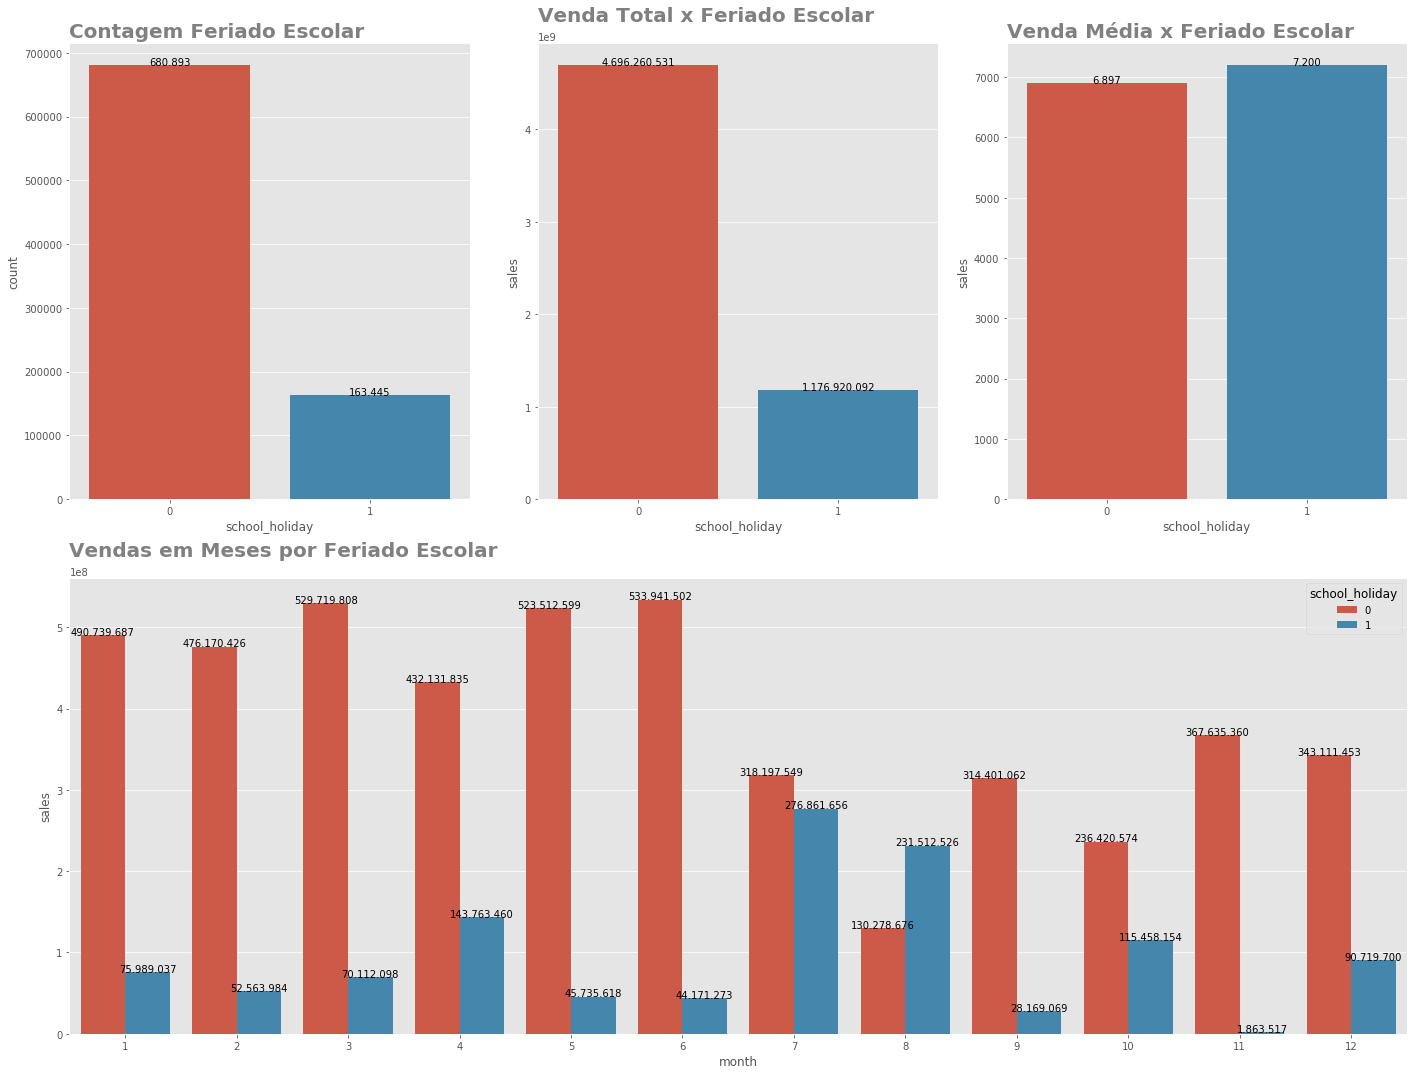

In [40]:
plt.figure(figsize= (20, 15))

aux1= aux1= df4[['sales', 'school_holiday', 'month']].groupby(['month', 'school_holiday']).sum().reset_index()

grid= GridSpec(2, 3)

plt.subplot(grid[0, 0])
ax= sns.countplot(x= 'school_holiday', data= df4)
titulo('Contagem Feriado Escolar', 20)
valor_grafico(aux1, 0 )

plt.subplot(grid[0, 1])
ax= sns.barplot(x= 'school_holiday', y= 'sales', data= df4, estimator= sum, ci= None)
titulo('Venda Total x Feriado Escolar', 20, 1.035)
valor_grafico(aux1, 0 )

plt.subplot(grid[0, 2])
ax= sns.barplot(x= 'school_holiday', y= 'sales', data= df4, ci= None)
titulo('Venda Média x Feriado Escolar', 20)
valor_grafico(aux1, 0 )

plt.subplot(grid[1, :])
ax= sns.barplot(x= 'month', y= 'sales', data= aux1, hue= 'school_holiday', estimator= sum, ci= None)
titulo('Vendas em Meses por Feriado Escolar', 20, 1.035)
valor_grafico(aux1, 0)

plt.tight_layout()

### **H10.** Lojas devem vender mais no Natal.
**Falso**. Observamos que o Natal vende menos do que os feriados publicos e na páscoa.

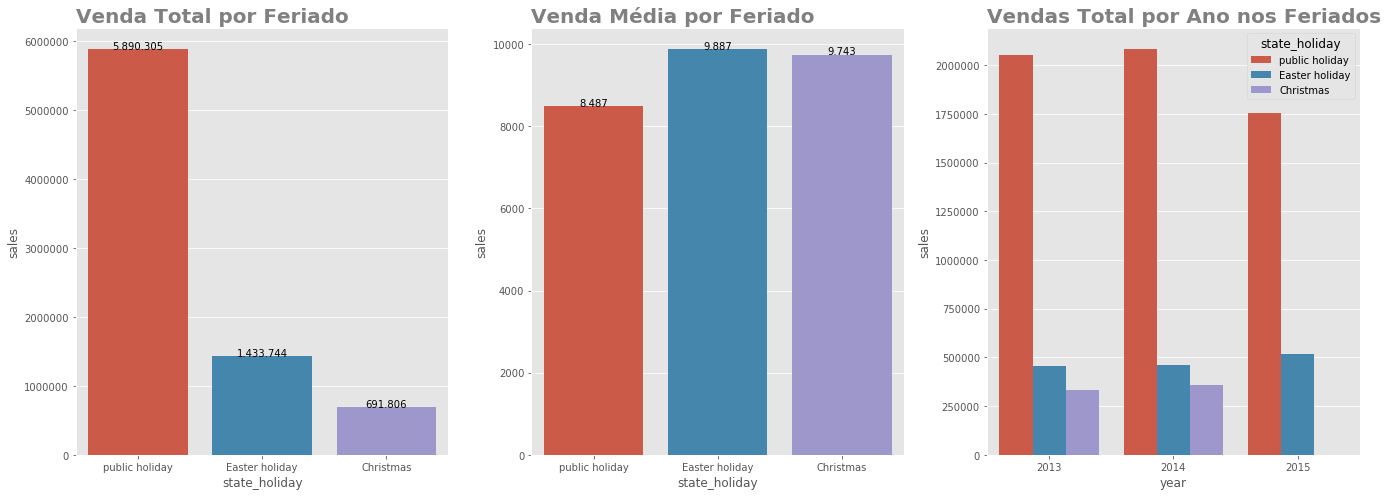

In [41]:
plt.figure(figsize= (20, 7))

plt.subplot(1, 3, 1)
ax= sns.barplot(x= 'state_holiday', y= 'sales', data= df4[df4['state_holiday'] != 'regular'], ci= None, estimator= sum)
titulo('Venda Total por Feriado', 20)
valor_grafico(df4[df4['state_holiday'] != 'regular'], 0)

plt.subplot(1, 3, 2)
ax= sns.barplot(x= 'state_holiday', y= 'sales', data= df4[df4['state_holiday'] != 'regular'], ci= None)
titulo('Venda Média por Feriado', 20)
valor_grafico(df4[df4['state_holiday'] != 'regular'], 0)

plt.subplot(1, 3, 3)
ax= sns.barplot(x= 'year', y= 'sales', data= df4[df4['state_holiday'] != 'regular'], hue= 'state_holiday', ci= None, estimator= sum)
titulo('Vendas Total por Ano nos Feriados', 20)

plt.tight_layout()

### 4.3. Análise Multivariada

### 4.3.1. Atributos Numéricos

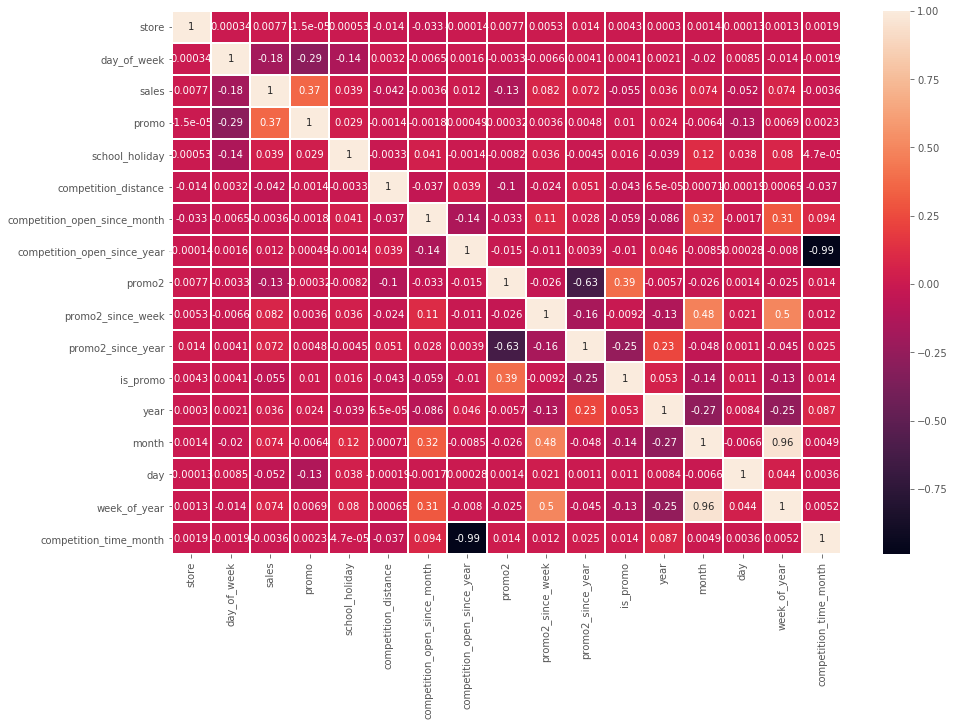

In [42]:
plt.figure(figsize= (15, 10))

sns.heatmap(df4.select_dtypes(include= ['float64', 'int64']).corr(), annot= True, linewidths= 1)

### 4.3.2. Atributos Categóricos

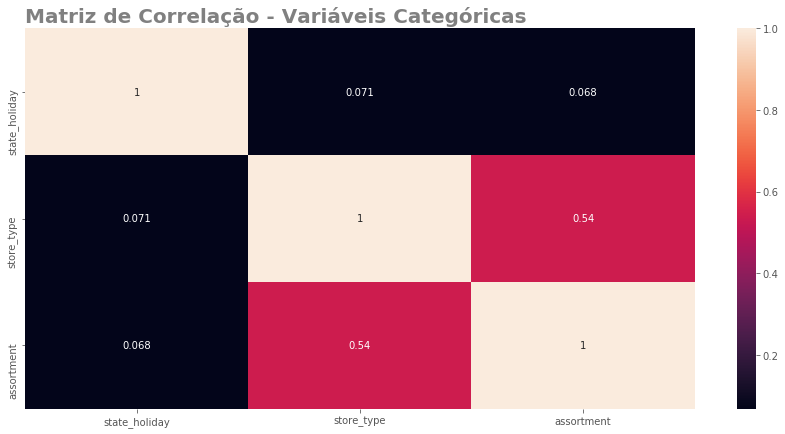

In [43]:
a= df4.select_dtypes(include= 'object')

a1= cramer_v(a['state_holiday'], a['state_holiday'])
a2= cramer_v(a['state_holiday'], a['store_type'])
a3= cramer_v(a['state_holiday'], a['assortment'])
a4= cramer_v(a['store_type'], a['state_holiday'])
a5= cramer_v(a['store_type'], a['store_type'])
a6= cramer_v(a['store_type'], a['assortment'])
a7= cramer_v(a['assortment'], a['state_holiday'])
a8= cramer_v(a['assortment'], a['store_type'])
a9= cramer_v(a['assortment'], a['assortment'])

d= pd.DataFrame({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]})
d= d.set_index(d.columns)

plt.figure(figsize= (15, 7))
sns.heatmap(d, annot= True)
titulo('Matriz de Correlação - Variáveis Categóricas', 20);

## 5.0. PREPARAÇÃO DOS DADOS

In [44]:
df5= df4.copy()

### 5.1. Normalização
Como podemos observar na seção 4.1.2, não apresentamos nenhuma variável numérica com distribuição normal, então não faremos a normalização dos dados.

### 5.2. Reescaling
Primeiro vamos selecionar as variáveis numéricas para depois observar as features que possuem outliers e as que não possuem para aplicar diferentes métodos de reescaling, sendo o RobustScaler para o primeiro e o MinMaxScaler para o segundo.

In [45]:
df5.select_dtypes(include= ['int64', 'float64']).head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84
1,1,4,5020,1,1,1270.0,9,2008,0,31,2015,0,2015,7,30,31,84
2,1,3,4782,1,1,1270.0,9,2008,0,31,2015,0,2015,7,29,31,84
3,1,2,5011,1,1,1270.0,9,2008,0,31,2015,0,2015,7,28,31,84
4,1,1,6102,1,1,1270.0,9,2008,0,31,2015,0,2015,7,27,31,84


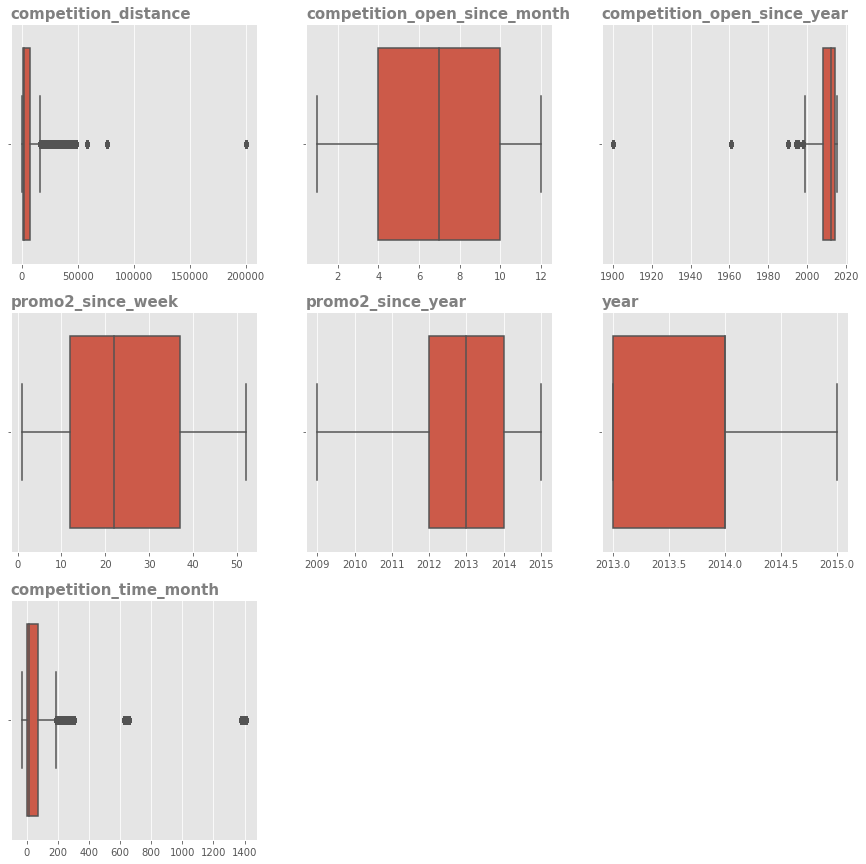

In [46]:
plt.figure(figsize= (15, 15))

lista= ['competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2_since_week','promo2_since_year', 'year', 'competition_time_month']

n= 1
for i in lista:
    plt.subplot(3, 3, n)
    sns.boxplot(x= i, data= df5)
    plt.xlabel('')
    titulo(i, 15)
    n+= 1

In [47]:
rb= RobustScaler()
mm= MinMaxScaler()

# RobustScaler
df5['competition_distance']= rb.fit_transform(df5[['competition_distance']].values)
pickle.dump(rb, open('Parametros/encoding_competition_distance.pkl', 'wb'))

df5['competition_open_since_year']= rb.fit_transform(df5[['competition_open_since_year']].values)
pickle.dump(rb, open('Parametros/encoding_competition_open_since_year.pkl', 'wb'))

df5['competition_time_month']= rb.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rb, open('Parametros/encoding_competition_time_month.pkl', 'wb'))

# MinMaxScaler
df5['competition_open_since_month']= mm.fit_transform(df5[['competition_open_since_month']].values)
pickle.dump(rb, open('Parametros/encoding_competition_open_since_month.pkl', 'wb'))

df5['promo2_since_week']= mm.fit_transform(df5[['promo2_since_week']].values)
pickle.dump(rb, open('Parametros/encoding_promo2_since_week.pkl', 'wb'))

df5['promo2_since_year']= mm.fit_transform(df5[['promo2_since_year']].values)
pickle.dump(rb, open('Parametros/encoding_promo2_since_year.pkl', 'wb'))

df5['year']= mm.fit_transform(df5[['year']].values)
pickle.dump(rb, open('Parametros/encoding_year.pkl', 'wb'))

### 5.3. Transformação 

#### 5.3.1. Encoding

#### Label Enconder ####

LabelEncoder é uma classe de utilitário para ajudar a normalizar rótulos de forma que contenham apenas valores entre 0 e n_classes-1. Pode ser usado para transformar rótulos não numéricos em rótulos numéricos.

#### One Hot Encoder ####

Esse tipo de codificação pode ser obtido com o OneHotEncoder e get_dummies, que transforma cada recurso categórico com valores possíveis de n_categories em recursos binários de ncategories, sendo um deles 1 e todos os outros 0. Por padrão, os valores que cada recurso pode assumir são inferidos automaticamente do conjunto de dados e podem ser encontrados no atributo categorias.

#### Ordinal Encoder #### 

Para converter recursos categóricos em códigos inteiros, podemos usar o OrdinalEncoder. Este estimador transforma cada recurso categórico em um novo recurso de números inteiros (0 a n_categories - 1) conforme ordenado.

Vamos pegar as features que são objects e transforma-las em numéricas através dos métodos abaixo:
- state_holiday: OneHot Encoding
- store_type: Label Enconding
- assortment: Ordinal Encoding

In [48]:
# state_holiday
df5= pd.get_dummies(df5, prefix= ['he_state_holiday'], columns= ['state_holiday'])

# store_type
le= LabelEncoder()
df5['store_type']= le.fit_transform(df5['store_type'])
pickle.dump(le, open('Parametros/encoding_store_type.pkl', 'wb'))

# assortment
assortment_encoder= {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment']= df5['assortment'].map(assortment_encoder)

#### 5.3.2. Variável Resposta
Vamos transformar a variável resposta o mais próxima de uma distribuição normal utilizando a função logaritmica.

In [49]:
df5['sales']= np.log(df5['sales'])

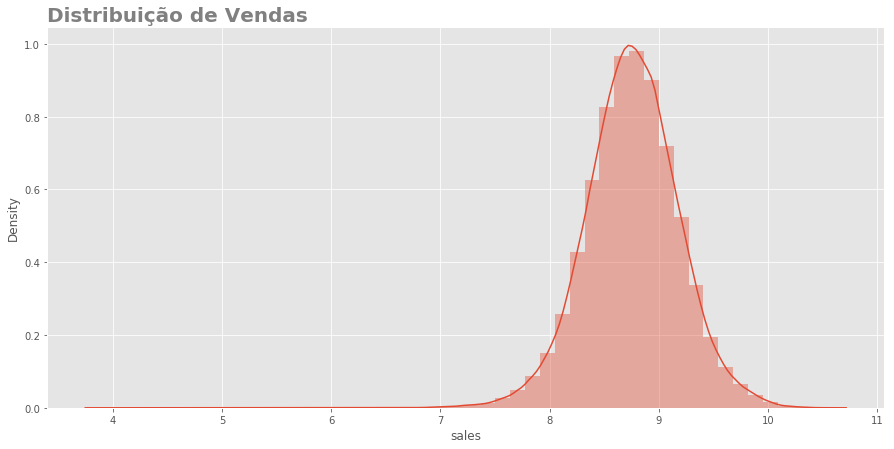

In [50]:
plt.figure(figsize= (15, 7))

sns.distplot(df5['sales'])
titulo('Distribuição de Vendas', 20)

#### 5.3.3. Transformação de Natureza Cíclica
As features relacionadas ao tempos(dia, semana, mês) possuem a natureza cíclica, ou seja, se repete ao longo do tempo. Então utilizaremos um método de transformação utilizando o seno e o cosseno.

In [51]:
# day_of_week
df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi) / 7))
df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi) / 7))

# month
df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2 * np.pi) / 12))
df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2 * np.pi) / 12))

# day
df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2 * np.pi) / 30))
df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2 * np.pi) / 30))

# week_of_year
df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi) / 52))
df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi) / 52))

In [52]:
df5.select_dtypes(include= ['int64', 'float64']).head()

,store,day_of_week,sales,promo,school_holiday,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,8.568456,1,1,1,-0.170968,0.727273,-0.666667,0,0.588235,1.0,0,1.0,7,31,31,0.918919,-0.974928,-0.222521,-0.5,-0.866025,2.079117e-01,0.978148,-0.568065,-0.822984
1,1,4,8.521185,1,1,1,-0.170968,0.727273,-0.666667,0,0.588235,1.0,0,1.0,7,30,31,0.918919,-0.433884,-0.900969,-0.5,-0.866025,-1.133108e-15,1.000000,-0.568065,-0.822984
2,1,3,8.472614,1,1,1,-0.170968,0.727273,-0.666667,0,0.588235,1.0,0,1.0,7,29,31,0.918919,0.433884,-0.900969,-0.5,-0.866025,-2.079117e-01,0.978148,-0.568065,-0.822984
3,1,2,8.519391,1,1,1,-0.170968,0.727273,-0.666667,0,0.588235,1.0,0,1.0,7,28,31,0.918919,0.974928,-0.222521,-0.5,-0.866025,-4.067366e-01,0.913545,-0.568065,-0.822984
4,1,1,8.716372,1,1,1,-0.170968,0.727273,-0.666667,0,0.588235,1.0,0,1.0,7,27,31,0.918919,0.781831,0.623490,-0.5,-0.866025,-5.877853e-01,0.809017,-0.568065,-0.822984


## 6.0. SELEÇÃO DE FEATURES

In [53]:
df6= df5.copy()

In [54]:
# Dropar as colunas que fizemos as transformações
drop_columns= ['day_of_week', 'month', 'day', 'week_of_year', 'year_week', 'competition_since']
df6.drop(columns= drop_columns, inplace= True)

### 6.1. Separar o Dataset em Treino e Teste
Estamos lidando com um problema temporal, ou seja, leva em questão o tempo, então vamos separar os dados de teste como sendo as últimas 6 semanas do dataset e os dados de treino o restante.

In [55]:
df6['date'].max() - datetime.timedelta(weeks= 6)

Timestamp('2015-06-19 00:00:00')

In [56]:
#Treino
x_train= df6[df6['date'] < '2015-06-19']
y_train= x_train['sales']

# Teste
x_test= df6[df6['date'] >= '2015-06-19']
y_test= x_test['sales']

In [57]:
print('A menor data nos dados de treino é {} e a maior data é {}'.format(x_train['date'].min(), x_train['date'].max()))
print('A menor data nos dados de teste  é {} e a maior data é {}'.format(x_test['date'].min(), x_test['date'].max()))

A menor data nos dados de treino é 2013-01-01 00:00:00 e a maior data é 2015-06-18 00:00:00
A menor data nos dados de teste  é 2015-06-19 00:00:00 e a maior data é 2015-07-31 00:00:00


In [58]:
# Retirando a variável alvo(sales) e a data(date) dos x
x_train_l= x_train.drop(columns= ['sales', 'date'])

### 6.2. Random Forest
RandomForest é um modelo que também pode ser usado como seleção de features, pois retorna as colunas mais relevantes de acordo com seu método.

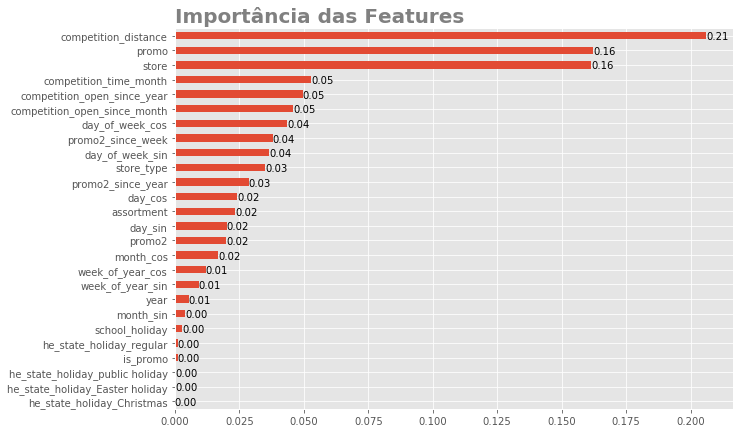

In [59]:
# Definindo modelo
rf_model = RandomForestRegressor(n_jobs = -1)
rf_model.fit(x_train_l, y_train)

# Vendo as features selecionadas
feat_importances = pd.Series(rf_model.feature_importances_, index=x_train_l.columns)

plt.figure(figsize= (10, 7))
ax= feat_importances.sort_values().plot(kind='barh')
titulo('Importância das Features', 20)

for patch in ax.patches:
    width= patch.get_width()
    left_coord= patch.get_y()
    
    ax.text(width, left_coord, '{:.2f}'.format(width))

### 6.3. Features Selecionadas

In [60]:
features_selected= feat_importances.sort_values(ascending= False).head(10).index.to_list()
features_selected

['competition_distance',
 'promo',
 'store',
 'competition_time_month',
 'competition_open_since_year',
 'competition_open_since_month',
 'day_of_week_cos',
 'promo2_since_week',
 'day_of_week_sin',
 'store_type']

In [61]:
X_train= x_train[features_selected]
X_test= x_test[features_selected]

In [62]:
x_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,he_state_holiday_Christmas,he_state_holiday_Easter holiday,he_state_holiday_public holiday,he_state_holiday_regular,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
43,1,2015-06-18,8.443547,1,0,2,1,-0.170968,0.727273,-0.666667,0,0.470588,1.0,0,1.0,0.891892,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-5.877853e-01,-0.809017,0.120537,-0.992709
44,1,2015-06-17,8.294050,1,0,2,1,-0.170968,0.727273,-0.666667,0,0.470588,1.0,0,1.0,0.891892,0,0,0,1,0.433884,-0.900969,1.224647e-16,-1.0,-4.067366e-01,-0.913545,0.120537,-0.992709
45,1,2015-06-16,8.487146,1,0,2,1,-0.170968,0.727273,-0.666667,0,0.470588,1.0,0,1.0,0.891892,0,0,0,1,0.974928,-0.222521,1.224647e-16,-1.0,-2.079117e-01,-0.978148,0.120537,-0.992709
46,1,2015-06-15,8.615771,1,0,2,1,-0.170968,0.727273,-0.666667,0,0.470588,1.0,0,1.0,0.891892,0,0,0,1,0.781831,0.623490,1.224647e-16,-1.0,5.665539e-16,-1.000000,0.120537,-0.992709
48,1,2015-06-13,8.356085,0,0,2,1,-0.170968,0.727273,-0.666667,0,0.450980,1.0,0,1.0,0.891892,0,0,0,1,-0.781831,0.623490,1.224647e-16,-1.0,4.067366e-01,-0.913545,0.239316,-0.970942


## 7.0. MACHINE LEARNING

### 7.1. Average Model

In [63]:
aux1= X_test.copy()
aux1['sales']= y_test
aux1['prediction']= y_test.mean()

In [64]:
avg_model= ml_error('AVERAGE MODEL', np.exp(aux1['sales']), np.exp(aux1['prediction']))
avg_model

,Model Name,MAE,MAPE,RMSE
0,AVERAGE MODEL,2198.103269,0.346326,3097.327981


### 7.2. Linear Regression Model

In [65]:
lr= LinearRegression()

lr.fit(X_train, y_train)
y_pred_lr= lr.predict(X_test)

In [66]:
lr_model= ml_error('LINEAR REGRESSION MODEL', np.exp(y_test), np.exp(y_pred_lr))
lr_model

,Model Name,MAE,MAPE,RMSE
0,LINEAR REGRESSION MODEL,1931.062155,0.310615,2733.264289


### 7.2.1 Linear Regression Model - Cross Validation

In [67]:
lr_model_cv= cross_validation(x_train, 5, 'Linear Regression CV', lr)
lr_model_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression CV,2037.68,0.3,2909.89


### 7.3. Lasso Model

In [68]:
lasso= Lasso()

lasso.fit(X_train, y_train)
y_pred_lasso= lasso.predict(X_test)

In [69]:
lasso_model= ml_error('LASSO MODEL', np.exp(y_test), np.exp(y_pred_lasso))
lasso_model

,Model Name,MAE,MAPE,RMSE
0,LASSO MODEL,2198.585843,0.342754,3110.534841


### 7.3.1. Lasso Model - Cross Validation

In [70]:
lasso_model_cv= cross_validation(x_train, 5, 'Lasso CV', lasso)
lasso_model_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso CV,2388.69,0.34,3369.4


### 7.4. Random Forest Regressor

In [71]:
rf= RandomForestRegressor()

rf.fit(X_train, y_train)
y_pred_rf= rf.predict(X_test)

In [72]:
rf_model= ml_error('RANDOM FOREST', np.exp(y_test), np.exp(y_pred_rf))
rf_model

,Model Name,MAE,MAPE,RMSE
0,RANDOM FOREST,670.587522,0.099594,986.126322


### 7.4.1. Random Forest Regressor

In [73]:
rf_model_cv= cross_validation(x_train, 5, 'Random Forest CV', rf, verbose= True)
rf_model_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest CV,814.86,0.11,1217.12


### 7.4. XGBoost Regressor

In [74]:
xg= xgb.XGBRegressor()

xg.fit(X_train, y_train)
y_pred_xg= xg.predict(X_test)

In [75]:
xg_model= ml_error('XGBOOST', np.exp(y_test), np.exp(y_pred_xg))
xg_model

,Model Name,MAE,MAPE,RMSE
0,XGBOOST,932.338561,0.139207,1355.381869


### 7.4.1. XGBoost Regressor

In [76]:
xg_model_cv= cross_validation(x_train, 5, 'XGBoost CV', xg, verbose= True)
xg_model_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost CV,1095.17,0.15,1574.26


### 7.5. Comparando Modelos

#### 7.5.1 Modelos Únicos

In [77]:
model_comparation= pd.concat([avg_model, lr_model, lasso_model, rf_model, xg_model]).reset_index(drop= True)
model_comparation.style.highlight_min(color= 'darkorange')

,Model Name,MAE,MAPE,RMSE
0,AVERAGE MODEL,2198.103269,0.346326,3097.327981
1,LINEAR REGRESSION MODEL,1931.062155,0.310615,2733.264289
2,LASSO MODEL,2198.585843,0.342754,3110.534841
3,RANDOM FOREST,670.587522,0.099594,986.126322
4,XGBOOST,932.338561,0.139207,1355.381869


#### 7.5.2. Modelos com Cross Validation

In [78]:
model_comparation_cv= pd.concat([lr_model_cv, lasso_model_cv, rf_model_cv, xg_model_cv]).reset_index(drop=True)
model_comparation_cv.style.highlight_min(color= 'darkorange')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression CV,2037.680000,0.300000,2909.890000
1,Lasso CV,2388.690000,0.340000,3369.400000
2,Random Forest CV,814.860000,0.110000,1217.120000
3,XGBoost CV,1095.170000,0.150000,1574.260000


## 8.0. INTERPRETANDO OS RESULTADOS

### 8.1. Visualização dos Erros
O modelo Random Forest foi o que melhor perfomou a frente dos dados, tendo o menor erro entre eles. Vamos utilizar as suas predições para analisar a performace por cada loja e apurar os resultados.

In [79]:
df7= x_test.copy()

In [80]:
df7['sales']= np.exp(df7['sales'])
df7['prediction']= np.exp(y_pred_rf)

In [81]:
aux1= df7[['store', 'prediction']].groupby('store').sum().reset_index()

In [82]:
aux_mae= df7[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns= {0: 'MAE'})
aux_mape= df7[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns= {0: 'MAPE'})

In [83]:
aux2= pd.merge(aux_mae, aux_mape, how= 'inner', on= 'store')
aux2.head()

,store,MAE,MAPE
0,1,289.160205,0.066524
1,2,439.004851,0.082942
2,3,689.654918,0.100629
3,4,862.249743,0.081157
4,5,411.988564,0.094562


In [84]:
df_results= pd.merge(aux1, aux2, how= 'inner', on= 'store')
df_results.head()

,store,prediction,MAE,MAPE
0,1,163857.164921,289.160205,0.066524
1,2,180318.305331,439.004851,0.082942
2,3,264786.444483,689.654918,0.100629
3,4,349003.127948,862.249743,0.081157
4,5,173518.162276,411.988564,0.094562


In [85]:
aux2[['MAE', 'MAPE']].describe().round(2)

,MAE,MAPE
count,1115.00,1115.00
mean,674.74,0.10
std,357.80,0.04
min,224.63,0.04
25%,486.54,0.08
50%,606.96,0.09
75%,779.50,0.11
max,7251.66,0.61


In [86]:
df_results['best_scenario']= df_results['prediction'] + df_results['MAE']
df_results['worst_scenario']= df_results['prediction'] - df_results['MAE']


df_results[['prediction', 'best_scenario', 'worst_scenario', 'MAE', 'MAPE']].round(2).head()

,prediction,best_scenario,worst_scenario,MAE,MAPE
0,163857.16,164146.33,163568.00,289.16,0.07
1,180318.31,180757.31,179879.30,439.00,0.08
2,264786.44,265476.10,264096.79,689.65,0.10
3,349003.13,349865.38,348140.88,862.25,0.08
4,173518.16,173930.15,173106.17,411.99,0.09


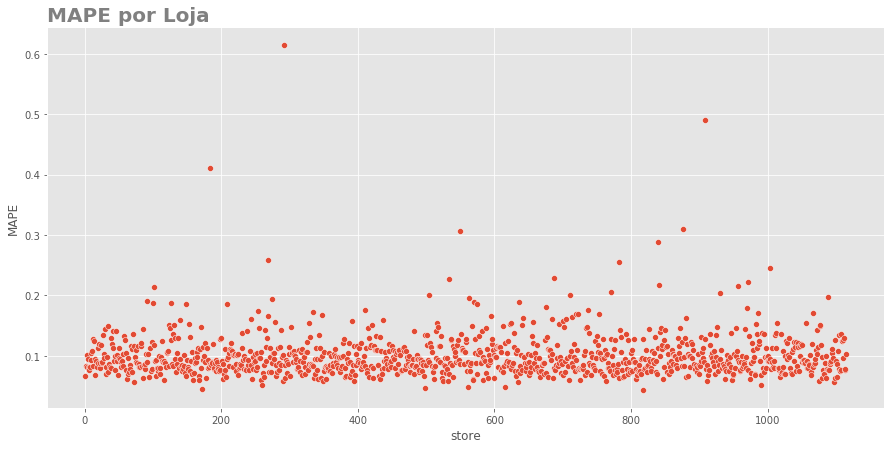

In [87]:
plt.figure(figsize= (15, 7))
sns.scatterplot(x= 'store', y= 'MAPE', data= df_results)
titulo('MAPE por Loja', 20)

In [88]:
df7['error']= df7['sales'] - df7['prediction']
df7['error_rate']= df7['prediction'] / df7['sales']

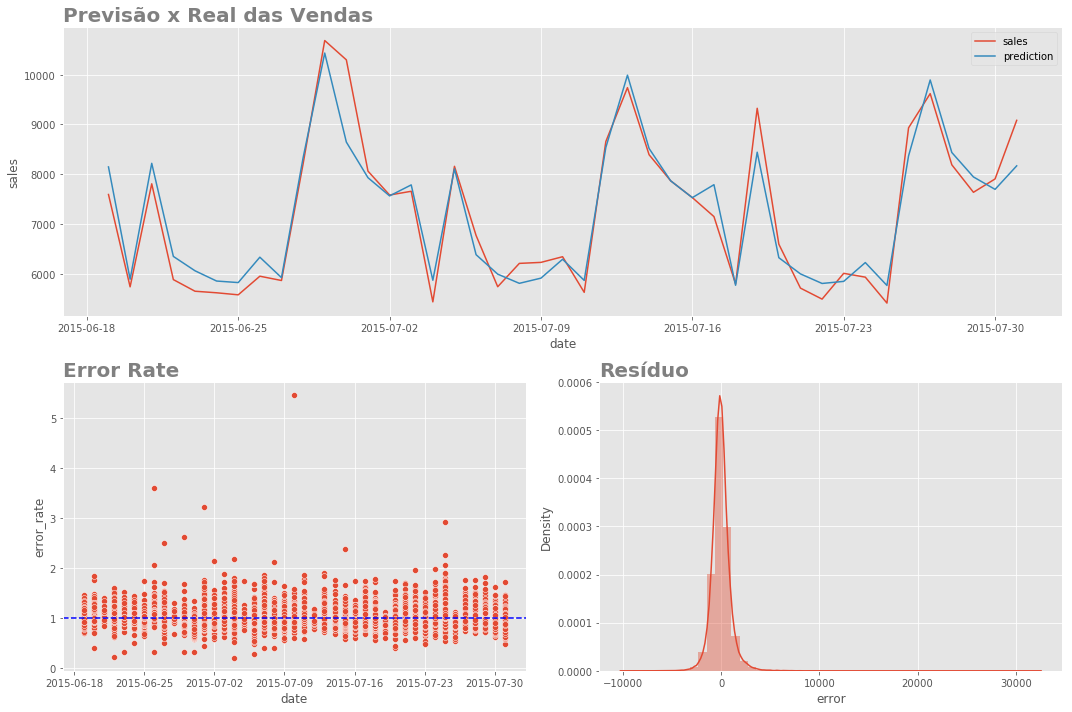

In [89]:
plt.figure(figsize= (15, 10))

grid= GridSpec(2, 2)

plt.subplot(grid[0, :])
sns.lineplot(x= 'date', y= 'sales', data= df7, label= 'sales', ci= None)
sns.lineplot(x= 'date', y= 'prediction', data= df7, label= 'prediction', ci= None)
titulo('Previsão x Real das Vendas', 20)
plt.legend()

plt.subplot(grid[1, 0])
sns.scatterplot(x= 'date', y= 'error_rate', data= df7)
titulo('Error Rate', 20)
plt.axhline(y= 1, color= 'blue', linestyle= '--')

plt.subplot(grid[1, 1])
sns.distplot(df7['error'])
titulo('Resíduo', 20)

plt.tight_layout();

In [90]:
aux2[['MAE', 'MAPE']].describe().round(2)

,MAE,MAPE
count,1115.00,1115.00
mean,674.74,0.10
std,357.80,0.04
min,224.63,0.04
25%,486.54,0.08
50%,606.96,0.09
75%,779.50,0.11
max,7251.66,0.61


### 8.2. Conclusão


- O modelo de regressão RandomForest obteve um erro absoluto médio(MAE) de  R$ 674,74 por loja, o que significa 10% de erro médio absoluto percentual(MAPE) nas previsões.

- Observando o gráfico da Previsão x Real de Vendas, podemos ver que as previsões do nosso modelo estão muito próximo do valor real de vendas.

- Tivemos uma grande variação no MAPE de algumas lojas, porém a grande maioria está abaixo de 15%.

- Observando o histograma, a distribuição do erro segue quase uma distribuição normal.

- Observando o gráfico do error rate, percebemos que a distribuição da previsão superestimou e subestimou aparentemente quase igual os resultados.